In [2]:
import numpy as np
import pandas as pd
import pickle
import glob
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import math
import cv2

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

pi = math.pi

%matplotlib inline

In [3]:
clinical_data = pd.read_csv('NSCLCR01Radiogenomic_DATA_LABELS_2018-05-22_1500-shifted.csv')
clinical_data = clinical_data.loc[clinical_data['Case ID']>='R01-001'] #Dropping AMC patients
clinical_data = clinical_data.loc[clinical_data['Case ID']<='R01-146'] #Dropping the rest of R01 patients (with no CT)

clinical_data = clinical_data[['Case ID', 'Pathological T stage',
                               'Pathological N stage', 'Pathological M stage']] #Dropping all irrelavant info

clinical_data.rename(columns = {'Case ID': 'ID',
                                'Pathological T stage': 'T',
                               'Pathological N stage' : 'N',
                               'Pathological M stage' : 'M'}, inplace = True)

# Dropping two patients who had no CT:
clinical_data = clinical_data[clinical_data.ID != 'R01-009']
clinical_data = clinical_data[clinical_data.ID != 'R01-143']

clinical_data['label'] = 0
clinical_data.loc[clinical_data.M != 'M0', 'label'] = 2
clinical_data.loc[(clinical_data.M != 'M0') | (clinical_data.N != 'N0'), 'label'] = 1

label0_count = clinical_data[(clinical_data.label == 0)].count()[0]
label1_count = clinical_data[(clinical_data.label == 1)].count()[0]
label2_count = clinical_data[(clinical_data.label == 2)].count()[0]
print('Class 0 count = %d patients. \nClass 1 count = %d patients. \nClass 2 count = %d patients'%
      (label0_count, label1_count, label2_count))
clinical_data.head(10)

Class 0 count = 112 patients. 
Class 1 count = 32 patients. 
Class 2 count = 0 patients


,ID,T,N,M,label
49,R01-001,T1a,N0,M0,0
50,R01-002,T1a,N0,M0,0
51,R01-003,T3,N0,M0,0
52,R01-004,T1b,N2,M0,1
53,R01-005,T2a,N0,M0,0
54,R01-006,T1b,N0,M0,0
55,R01-007,T1a,N1,M0,1
56,R01-008,Tis,N0,M0,0
58,R01-010,T3,N0,M0,0
59,R01-011,T1a,N2,M0,1


In [4]:
labels = clinical_data.iloc[:,-1].values
patients_names = clinical_data.iloc[:,0].values
del clinical_data
labels

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1])

In [5]:
"""                                    Basic functions and data constants                                            """




"""Data constants"""

Max_tumor_shape = [111, 119, 149]
list_of_patients = glob.glob('*.pickle')
list_of_patients.sort()

################################################################################
""" Functions """

def crop_tumor(patient):
    
    Z, Y, X = [111, 119, 149] # Max tumor shape
    
    img = patient['img']
    mask = patient['mask']
    
    z_values, y_values, x_values = np.where(mask==1)
    
    z_tumor_begining = np.min(z_values)
    y_tumor_begining = np.min(y_values)
    x_tumor_begining = np.min(x_values)
    
    z_tumor_end = z_tumor_begining + int(Z)
    y_tumor_end = y_tumor_begining + int(Y)
    x_tumor_end = x_tumor_begining + int(X)
    
    img = img[z_tumor_begining : z_tumor_end,
              y_tumor_begining : y_tumor_end,
              x_tumor_begining : x_tumor_end]
    
    mask = mask[z_tumor_begining : z_tumor_end,
                y_tumor_begining : y_tumor_end,
                x_tumor_begining : x_tumor_end]
    
    if img.shape < (Z,Y,X):
        img  = np.pad(img,  ((0,Z- img.shape[0]),(0,Y- img.shape[1]), (0,X- img.shape[2])),'constant')
        mask = np.pad(mask, ((0,Z-mask.shape[0]),(0,Y-mask.shape[1]), (0,X-mask.shape[2])),'constant')
    
    tumor = img*mask                                                 ###Tune###
#     tumor = img
    tumor = tumor.astype('float32')
    return tumor

################################################################################

def crop_exact_tumor(patient, mode=1):
    
    img = patient['img']
    mask = patient['mask']
    
    z_values, y_values, x_values = np.where(mask==1)
    
    z_tumor_begining = np.min(z_values)
    y_tumor_begining = np.min(y_values)
    x_tumor_begining = np.min(x_values)
    
    z_tumor_end = np.max(z_values) + 1
    y_tumor_end = np.max(y_values) + 10
    x_tumor_end = np.max(x_values) + 10
    
    img = img[z_tumor_begining : z_tumor_end,
              y_tumor_begining : y_tumor_end,
              x_tumor_begining : x_tumor_end]
    
    mask = mask[z_tumor_begining : z_tumor_end,
                y_tumor_begining : y_tumor_end,
                x_tumor_begining : x_tumor_end]
    
    if mode: tumor = img
    else: tumor = mask*img ############## TUNE
        
    tumor = tumor.astype('float32')
    return tumor
    
################################################################################

def get_tumor_volume(patient):
    volume = 0
    
    mask = patient['mask']
    tags = patient['tags']
    
    SliceThickness = float(tags['SliceThickness'])
    
    PixelSpacing = tags['PixelSpacing']
    PixelSpacing = PixelSpacing.split()
    PixelSpacing = float(PixelSpacing[0][2:-3])
    
    VoxelSize = PixelSpacing*PixelSpacing*SliceThickness
    no_of_voxels = np.count_nonzero(mask)
    
    return (VoxelSize*no_of_voxels)

################################################################################

def get_tumor_surface_area (patient):
    area = 0
        
    mask = patient['mask']
    tags = patient['tags']
    
    SliceThickness = float(tags['SliceThickness'])
    PixelSpacing = tags['PixelSpacing']
    PixelSpacing = PixelSpacing.split()
    PixelSpacing = float(PixelSpacing[0][2:-3])
    
    #tumor = crop_exact_tumor(patient, 0)
    tumor = mask
    
    last_tumor_slice = np.max(np.where(tumor>0)[0])
    
    for i in range(last_tumor_slice):
        img = tumor[i].copy()
        img[img!=0]=255
        contours, _ = cv2.findContours(img.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        perimeter = 0
        for cnt in contours:
            perimeter += cv2.arcLength(cnt, True)
            
        if i == 0 or i == last_tumor_slice:
            tumor_pixels_count = np.count_nonzero(img)
            area += tumor_pixels_count * (PixelSpacing**2)
            area += perimeter * 0.5*SliceThickness
        else:
            area += perimeter * SliceThickness
            
    return area

###############################################################################

def get_distance(pt1, pt2, slice_spacing, pixel_distance):
    pt1, pt2 = np.array(pt1, dtype=float), np.array(pt2, dtype=float)
    z_coeff = pixel_distance/slice_spacing
    dist = pt1 - pt2
    dist[2]*= z_coeff
    return (np.sum(dist**2, axis=0))

###############################################################################

def get_contour_voxels(tumor):
    last_tumor_slice = np.max(np.where(tumor>0)[0])
    
    for i in range(last_tumor_slice):
        img = tumor[i].copy()
        img[img!=0]=255
        contours, _ = cv2.findContours(img.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        

################################################################################

def get_centroid(tumor):
    tumor[tumor>0]=1
    coords = np.asarray(np.where(tumor)).T
    c = np.mean(coords, axis=0)
    return c.round()

################################################################################
    
def get_mean_img(list_of_patients):
    sum_imgs = np.zeros(Max_tumor_shape)
    for name in list_of_patients:
        print(name)
        patient = pickle.load(open(name, 'rb'))
        sum_imgs += crop_tumor(patient)
        print('\n')
        
    return sum_imgs/len(list_of_patients)

#################################################################################

def standardize_feature_matrix(X):
    min_X = X.min(axis=1)[:,None]
    max_X = X.max(axis=1)[:,None]
    
    return (X- min_X) / (max_X - min_X)

################################################################################

def normalize_feature_matrix(X):
    mean_X = X.mean(axis=1)[:,None]
    std_X = X.std(axis=1)[:,None]
    
    return (X- mean_X) / std_X


In [6]:
"""                                        *** Features functions ***                                                """


""" First group features """
##  Statistical features

def Energy(tumor):
    return np.sum(tumor**2)

def Entropy(tumor):
    P, _ = np.histogram(tumor)                 ### Tune number of bins, default = 10 ###
    P = P.astype('float64')
    P[P==0]= 1e-5
    return np.sum(P*np.log2(P))
        
def Kurtosis(tumor):
    N = np.count_nonzero(tumor)
    mean_voxel = np.sum(tumor)/N
    num = 1.0/N * np.sum((tumor-mean_voxel)**4)
    den = (np.sqrt(np.sum((tumor-mean_voxel)**2)))**2
    return num/den

def Maximum(tumor):
    return np.max(tumor)

def Mean(tumor):
    N = np.count_nonzero(tumor)
    return np.sum(tumor)/N

def Mean_abs_dev(tumor):
    N = np.count_nonzero(tumor)
    mean_voxel = np.sum(tumor)/N
    return np.sum(tumor - mean_voxel)

def Median(tumor):
    return np.median(tumor[np.nonzero(tumor)])

def Minimum(tumor):
    return np.min(tumor[np.nonzero(tumor)])

def Range(tumor):
    return np.max(tumor)-np.min(tumor[np.nonzero(tumor)])

def RMS(tumor):
    N = np.count_nonzero(tumor)
    return np.sqrt(np.sum(tumor**2)/N)

def Skewness(tumor):
    N = np.count_nonzero(tumor)
    mean_voxel = np.sum(tumor)/N
    num = 1.0/N * np.sum((tumor-mean_voxel)**3)
    den = (np.sqrt(1.0/N * np.sum((tumor-mean_voxel)**2)))**3
    return num/den

def std(tumor):
    return np.std(tumor)

def Uniformity(tumor):
    hist, _ = np.histogram(tumor)
    return np.sum(hist**2)

def Variance(tumor):
    N = np.count_nonzero(tumor)
    mean_voxel = np.sum(tumor)/N
    var = 1.0/(N-1) * np.sum ((tumor-mean_voxel)**2)
    return var

Statistcal_features = [Energy, Entropy, Kurtosis, Maximum, Mean, Mean_abs_dev,
                       Median, Minimum, Range, RMS, Skewness, std, Uniformity, Variance]
    
########################################################################

""" Second group features """
##  Shape & size features


def Compactness1 (patient):
    num = get_tumor_volume(patient)
    den = (pi**0.5) * get_tumor_surface_area(patient)**(2.0/3.0)
    return num/den

def Compactness2 (patient):
    num = 36 * pi * get_tumor_volume(patient)**2
    den = get_tumor_surface_area(patient)**3
    return num/den

def Max_3D_diameter (patient):
    tumor = crop_exact_tumor(patient, 0)
    pts = np.array(np.where(tumor>0)).T
    hull = ConvexHull(pts)
    pts = pts[hull.vertices].T
    p1, p2 = pts[...,None], pts[:,None]
    
    tags = patient['tags']
    SliceThickness = float(tags['SliceThickness'])
    PixelSpacing = tags['PixelSpacing']
    PixelSpacing = PixelSpacing.split()
    PixelSpacing = float(PixelSpacing[0][2:-3])
    diameters = get_distance(p1, p2, SliceThickness, PixelSpacing)
    return np.max(diameters)

def Spherical_disproportion(patient):
    A = get_tumor_surface_area(patient)
    V = get_tumor_volume(patient)
    R = (3*V/(4*pi))**(1.0/3.0)
    return (A/(4*pi*(R**2)))

def Sphericity (patient):
    V = get_tumor_volume(patient)
    num = pi**(1.0/3.0) * (6*V)**(2.0/3.0)
    A = get_tumor_surface_area(patient)
    return num/A
            
def Surface_area (patient):
    return get_tumor_surface_area(patient)

def Surface_to_volume_ratio (patient):
    A = get_tumor_surface_area(patient)
    V = get_tumor_volume(patient)
    return A/V
            
def Volume(patient):
    return get_tumor_volume(patient)

Shape_size_features = [Compactness1, Compactness2, Max_3D_diameter, Spherical_disproportion, Sphericity, \
                       Surface_area, Surface_to_volume_ratio, Volume]

In [7]:
# """                                        Testing cell                                                              """

# features_matrix = []

# for name in list_of_patients:
#     patient = pickle.load(open(name, 'rb'))
#     print ('%s\r'%patient['tags']['PatientID'], end='')
# #     tumor = crop_exact_tumor(patient, 1)
#     features = [feature(patient) for feature in Shape_size_features]
#     features_matrix.append(features)

# features_matrix = np.asarray(features_matrix)
# print('\t\tDone! :) \n')

In [8]:
# features_matrix.shape

In [9]:
""" Extracting feature vector for all patients """

feature_groups = [Statistcal_features, Shape_size_features]
feature_groups_names = ['Statistcal_features', 'Shape_size_features']

for i, group in enumerate(feature_groups):
    i, group = 1, Shape_size_features
    print('Working on '+ feature_groups_names[i])
    shape_features_matrix = len(list_of_patients), len(group)
    features_matrix = np.empty(shape_features_matrix)
    for p, name in enumerate(list_of_patients):
        patient = pickle.load(open(name, 'rb'))
        print ('%s\r'%patient['tags']['PatientID'], end='')
        tumor = crop_exact_tumor(patient, 1)
        if i==0: matrix = [feature(tumor) for feature in group]
        else: matrix = [feature(patient) for feature in group]
        features_matrix[p] = matrix
    features_matrix = np.asarray(features_matrix)
    np.save(open(feature_groups_names[i], 'wb'), features_matrix)
    
print('\t\tDone! :) \n')

Working on Shape_size_features
		Done! :) 



In [ ]:
"""    ^^^ UP HERE ^^^ """

In [11]:
i, group = 0, Statistcal_features
print('Working on '+ feature_groups_names[i])
shape_features_matrix = len(list_of_patients), len(group)
features_matrix = np.empty(shape_features_matrix)
for p, name in enumerate(list_of_patients):
    patient = pickle.load(open(name, 'rb'))
    print ('%s\r'%patient['tags']['PatientID'], end='')
    tumor = crop_exact_tumor(patient, 0)
    if i==0: matrix = [feature(tumor) for feature in group]
    else: matrix = [feature(patient) for feature in group]
    features_matrix[p] = matrix
features_matrix = np.asarray(features_matrix)
np.save(open("Statistical_no_surrouding", 'wb'), features_matrix)
    
print('\t\tDone! :) \n')

Working on Statistcal_features
		Done! :) 



In [45]:
""" Extracting feature vector for all patients """

features_matrix = []

for name in list_of_patients:
    patient = pickle.load(open(name, 'rb'))
    print ('%s\r'%patient['tags']['PatientID'], end='')
    tumor = crop_exact_tumor(patient, 1)
#     group1_features = [feature(tumor) for feature in Statistcal_features]
    group2_features = [feature(patient) for feature in Shape_size_features]
    features =  group2_features
    features_matrix.append(features)

features_matrix = np.asarray(features_matrix)
print('\t\tDone! :) \n')

		Done! :) 



In [46]:
np.save(open('1st_features_exact', 'wb'), features_matrix)

In [41]:
k = 5

if not np.array_equal(features_matrix[:,-1],labels): features_matrix = np.hstack((features_matrix, labels[:,None]))

X0 = features_matrix[features_matrix[:,-1]==0]
X1 = features_matrix[features_matrix[:,-1]==1]

X0_folds = np.array_split(X0, k)
X1_folds = np.array_split(X1, k)

Avg_acc_MLP, Avg_fn = 0, 0

for i in range(k):
    print('Fold %d/%d is the validation fold:'%(i+1, k))
    
    X0_train = np.concatenate([X0_folds[j] for j in range(k) if j!=i])
    X1_train = np.concatenate([X1_folds[j] for j in range(k) if j!=i])
    
    X0_val = X0_folds[i]
    X1_val = X1_folds[i]
    
    x_train = np.concatenate((X0_train, X1_train), axis=0)
    x_val = np.concatenate((X0_val, X1_val), axis=0)
    
    np.random.shuffle(x_train)
    np.random.shuffle(x_val)
    
    y_train = x_train[:,-1]
    y_val = x_val[:,-1]
    
    x_train = x_train[:,:-1]
    x_val = x_val[:,:-1]

    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_val = scaler.transform(x_val)

    
    clf = MLPClassifier(solver='lbfgs', alpha=1e-10, hidden_layer_sizes=(1000, 100, 100), random_state=1, max_iter=500)
    clf.fit(x_train, y_train)
    
    MLP_result = clf.score(x_val, y_val)*100
    
    print('MLP accuracy: ', MLP_result, '%\n')
    
    Avg_acc_MLP += MLP_result
    
    nm = np.asarray(np.where(y_val==1))
    nm = nm.reshape(nm.size)
    fn = (1-clf.score(x_val[nm], y_val[nm]))*100
    print('False negative: ', fn, '\n\n\n')
    Avg_fn += fn
    

Avg_acc_MLP /= k
Avg_fn /= k

print('\t\t ------------------------------------------------------------')
print('\t\t| Average MLP accuracy:                 ', Avg_acc_MLP, '% |')
print('\t\t| Average false negative:               ', Avg_fn, '% |')
print('\t\t ------------------------------------------------------------\n')

Fold 1/5 is the validation fold:
MLP accuracy:  53.333333333333336 %

False negative:  71.42857142857143 



Fold 2/5 is the validation fold:
MLP accuracy:  80.0 %

False negative:  42.85714285714286 



Fold 3/5 is the validation fold:
MLP accuracy:  39.285714285714285 %

False negative:  100.0 



Fold 4/5 is the validation fold:
MLP accuracy:  71.42857142857143 %

False negative:  66.66666666666667 



Fold 5/5 is the validation fold:
MLP accuracy:  67.85714285714286 %

False negative:  83.33333333333334 



		 ------------------------------------------------------------
		| Average MLP accuracy:                  62.38095238095239 % |
		| Average false negative:                72.85714285714286 % |
		 ------------------------------------------------------------



In [29]:
nfeatures_matrix = standardize_feature_matrix(features_matrix)                   ## normalize or standardize?
nfeatures_matrix[:3]

(144, 22)

In [31]:
if not np.array_equal(nfeatures_matrix[:,-1],labels): nfeatures_matrix = np.hstack((nfeatures_matrix, labels[:,None]))
nfeatures_matrix.shape

(144, 23)

In [30]:
x_train = nfeatures_matrix[:100,:-1]
y_train = labels[:100]

x_val = nfeatures_matrix[100:,:-1]
y_val = labels[100:]

In [31]:
clf = LogisticRegression(class_weight= 'balanced', solver='liblinear')

clf.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
clf.score(x_val, y_val)

0.6818181818181818

In [35]:
clf2 = SVC(kernel='linear', class_weight='balanced')

clf2.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [36]:
clf2.score(x_val, y_val)

0.7954545454545454

In [321]:
""" K-fold using crop_tumor """

k = 5
folds = np.array_split(nfeatures_matrix, k)
folds_labels = np.array_split(labels, k)

training_folds_shape = (k-1)*len(folds[0]), nfeatures_matrix.shape[1]

for i, fold in enumerate(folds):
    print('Fold %d/%d is the validation fold:'%(i+1, k))
    
    x_train = np.concatenate([folds[j] for j in range(k) if j!=i])
    y_train = np.concatenate([folds_labels[j] for j in range(k) if j!=i])
    
    x_val = fold
    y_val = folds_labels[i]
    
    clf = LogisticRegression(class_weight= 'balanced', solver='liblinear')
    clf.fit(x_train, y_train)
    
    print('Logistic regression accuracy: ', clf.score(x_val, y_val)*100, '%')
    
    clf2 = SVC(kernel='linear', class_weight='balanced')
    clf2.fit(x_train, y_train)
    
    print('SVM accuracy: ', clf2.score(x_val, y_val)*100, '%\n')

Fold 1/5 is the validation fold:
Logistic regression accuracy:  65.51724137931035 %
SVM accuracy:  82.75862068965517 %

Fold 2/5 is the validation fold:
Logistic regression accuracy:  72.41379310344827 %
SVM accuracy:  27.586206896551722 %

Fold 3/5 is the validation fold:
Logistic regression accuracy:  79.3103448275862 %
SVM accuracy:  27.586206896551722 %

Fold 4/5 is the validation fold:
Logistic regression accuracy:  75.86206896551724 %
SVM accuracy:  20.689655172413794 %

Fold 5/5 is the validation fold:
Logistic regression accuracy:  89.28571428571429 %
SVM accuracy:  17.857142857142858 %



In [33]:
""" K-fold using crop_exact_tumor """


k = 5


X0 = nfeatures_matrix[nfeatures_matrix[:,-1]==0]
X1 = nfeatures_matrix[nfeatures_matrix[:,-1]==1]


X0_folds = np.array_split(X0, k)
X1_folds = np.array_split(X1, k)



# folds = np.array_split(nfeatures_matrix[:,:-1], k)
# folds_labels = np.array_split(labels, k)


Avg_acc_logistic_regression, Avg_acc_SVM = 0, 0
Logistic_reg_fn, SVM_FN = 0, 0


for i in range(k):
    print('Fold %d/%d is the validation fold:'%(i+1, k))
    
    X0_train = np.concatenate([X0_folds[j] for j in range(k) if j!=i])
    X1_train = np.concatenate([X1_folds[j] for j in range(k) if j!=i])
    
    X0_val = X0_folds[i]
    X1_val = X1_folds[i]
    
    x_train = np.concatenate((X0_train, X1_train), axis=0)
    x_val = np.concatenate((X0_val, X1_val), axis=0)
    
    np.random.shuffle(x_train)
    np.random.shuffle(x_val)
    
    y_train = x_train[:,-1]
    y_val = x_val[:,-1]
    
    x_train = x_train[:,:-1]
    x_val = x_val[:,:-1]
    
    
#     x_train = np.concatenate([folds[j] for j in range(k) if j!=i])
#     y_train = np.concatenate([folds_labels[j] for j in range(k) if j!=i])
    
#     x_val = folds[i]
#     y_val = folds_labels[i]


    nm = np.asarray(np.where(y_val==1))
    nm = nm.reshape(nm.size)
    
    
    clf = LogisticRegression(class_weight= 'balanced', solver='liblinear')
    clf.fit(x_train, y_train)
    
    Logistic_regression_result = clf.score(x_val, y_val)*100
    log_reg_fn = (1-clf.score(x_val[nm], y_val[nm]))*100
    
    print('Logistic regression accuracy: ', Logistic_regression_result, '%')
    print('Logistic regression False negative: ', log_reg_fn, '%')
    
    clf2 = SVC(kernel='linear', class_weight='balanced')
    clf2.fit(x_train, y_train)
    
    SVM_result = clf2.score(x_val, y_val)*100
    SVM_fn = (1-clf2.score(x_val[nm], y_val[nm]))*100
    
    print('SVM accuracy: ', SVM_result, '%')
    
    Avg_acc_logistic_regression += Logistic_regression_result
    Avg_acc_SVM += SVM_result
    
    print('SVM False Negative: ', SVM_fn, '%\n\n\n')
    
    Logistic_reg_fn += log_reg_fn
    SVM_FN += SVM_fn
    

    
Avg_acc_logistic_regression /= k
Avg_acc_SVM /= k
Logistic_reg_fn /= k
SVM_FN /= k

print('\t\t ------------------------------------------------------------')
print('\t\t| Average logistic regression accuracy: ', Avg_acc_logistic_regression, '% |')
print('\t\t| Average logistic regression FN:       ', Logistic_reg_fn, '% |')
print('\t\t| Average SVM accuracy:                 ', Avg_acc_SVM, '% |')
print('\t\t| Average SVM FN:                       ', SVM_FN, '% |')
print('\t\t ------------------------------------------------------------\n')

Fold 1/5 is the validation fold:
Logistic regression accuracy:  60.0 %
Logistic regression False negative:  85.71428571428572 %
SVM accuracy:  66.66666666666666 %
SVM False Negative:  85.71428571428572 %



Fold 2/5 is the validation fold:
Logistic regression accuracy:  86.66666666666667 %
Logistic regression False negative:  42.85714285714286 %
SVM accuracy:  76.66666666666667 %
SVM False Negative:  100.0 %



Fold 3/5 is the validation fold:
Logistic regression accuracy:  75.0 %
Logistic regression False negative:  50.0 %
SVM accuracy:  78.57142857142857 %
SVM False Negative:  66.66666666666667 %



Fold 4/5 is the validation fold:
Logistic regression accuracy:  71.42857142857143 %
Logistic regression False negative:  33.333333333333336 %
SVM accuracy:  78.57142857142857 %
SVM False Negative:  83.33333333333334 %



Fold 5/5 is the validation fold:
Logistic regression accuracy:  64.28571428571429 %
Logistic regression False negative:  50.0 %
SVM accuracy:  71.42857142857143 %
SVM Fal

In [25]:
test = 'R01-016.pickle'
p = pickle.load(open(test, 'rb'))
t = crop_tumor(p)

Statistcal_features = [Energy, Entropy, Kurtosis, Maximum, Mean, Mean_abs_dev,
                       Median, Minimum, Range, RMS, Skewness, std, Uniformity, Variance]

for func in Statistcal_features:
    print(func.__name__, ': ', func(t))

Energy :  1150948500.0
Entropy :  41131611.11710582
Kurtosis :  629.1782214874727
Maximum :  1170.0
Mean :  913.4072398190045
Mean_abs_dev :  -1796501400.0
Median :  996.5
Minimum :  261.0
Range :  909.0
RMS :  931.6572755228667
Skewness :  -0.025964157179032412
std :  24.17452
Uniformity :  3868361655705
Variance :  1238481027.3811321


In [5]:
test = pickle.load(open('R01-001.pickle', 'rb'))

SpacingBetweenSlices = float(test['tags']['SpacingBetweenSlices'])
SliceThickness = float(test['tags']['SliceThickness'])
PixelSpacing = test['tags']['PixelSpacing']
PixelSpacing = PixelSpacing.split()
PixelSpacing = float(PixelSpacing[0][2:-3])
print(PixelSpacing)
#SpacingBetweenSlices/PixelSpacing

list_of_patients = glob.glob('*.pickle')
list_of_patients.sort()
    

0.69335937


In [35]:
Max_tumor_shape = -1*np.ones(3)

for name in list_of_patients:
    patient = pickle.load(open(name, 'rb'))
    mask = patient['mask']
    no_of_slices = mask.shape[0]
    print(name)
    #print(no_of_slices)
    
    z_values, y_values, x_values = np.where(mask==1)
    
    z_min = np.min(z_values)
    z_max = np.max(z_values)
    
    y_min = np.min(y_values)
    y_max = np.max(y_values)
    
    x_min = np.min(x_values)
    x_max = np.max(x_values)
    
    z_diff = z_max - z_min
    y_diff = y_max - y_min
    x_diff = x_max - x_min
    
    
    if z_diff > Max_tumor_shape[0]:
        Max_tumor_shape[0] = z_diff
    if x_diff > Max_tumor_shape[1]:
        Max_tumor_shape[1] = y_diff
    if y_diff > Max_tumor_shape[2]:
        Max_tumor_shape[2] = x_diff
    
    #print(z_min, z_max, x_min, x_max, y_min, y_max)
    print(Max_tumor_shape, '\n')
        

R01-001.pickle
[19. 20. 25.] 

R01-002.pickle
[19. 20. 25.] 

R01-003.pickle
[19. 20. 25.] 

R01-004.pickle
[19. 20. 25.] 

R01-005.pickle
[25. 45. 47.] 

R01-006.pickle
[39. 45. 47.] 

R01-007.pickle
[39. 45. 47.] 

R01-008.pickle
[39. 45. 47.] 

R01-010.pickle
[59. 75. 72.] 

R01-011.pickle
[59. 75. 72.] 

R01-012.pickle
[ 63.  99. 103.] 

R01-013.pickle
[ 63.  99. 103.] 

R01-014.pickle
[ 63.  99. 103.] 

R01-015.pickle
[ 69.  99. 103.] 

R01-016.pickle
[ 69.  99. 103.] 

R01-017.pickle
[ 69.  99. 103.] 

R01-018.pickle
[ 87.  99. 103.] 

R01-019.pickle
[ 87.  99. 103.] 

R01-020.pickle
[ 87.  99. 103.] 

R01-021.pickle
[ 87.  99. 103.] 

R01-022.pickle
[ 87.  99. 103.] 

R01-023.pickle
[ 87.  99. 103.] 

R01-024.pickle
[ 87.  99. 103.] 

R01-025.pickle
[ 87.  99. 103.] 

R01-026.pickle
[ 87.  99. 103.] 

R01-027.pickle
[ 87.  99. 103.] 

R01-028.pickle
[ 87.  99. 103.] 

R01-029.pickle
[ 87.  99. 103.] 

R01-030.pickle
[ 87.  99. 103.] 

R01-031.pickle
[ 87.  99. 103.] 

R01-032.pi

(248, 512, 512)
(112, 150, 120)


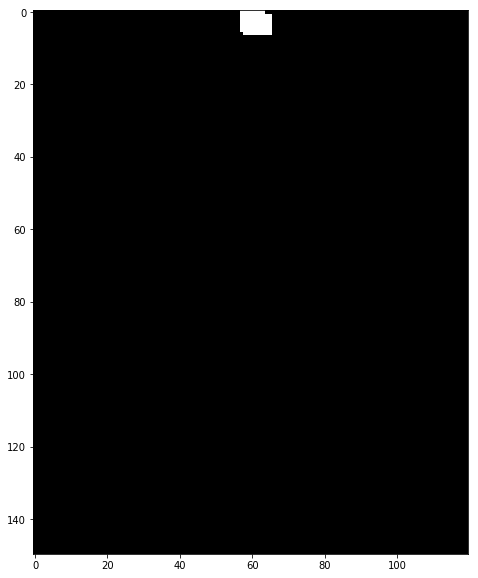

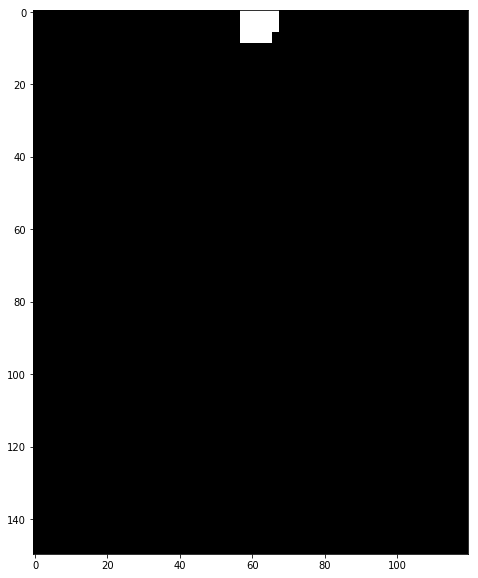

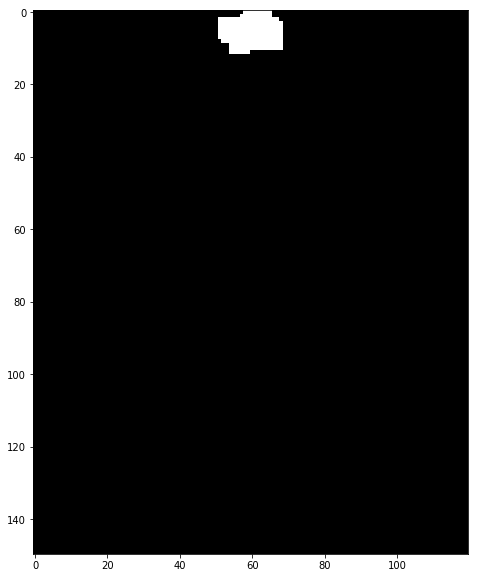

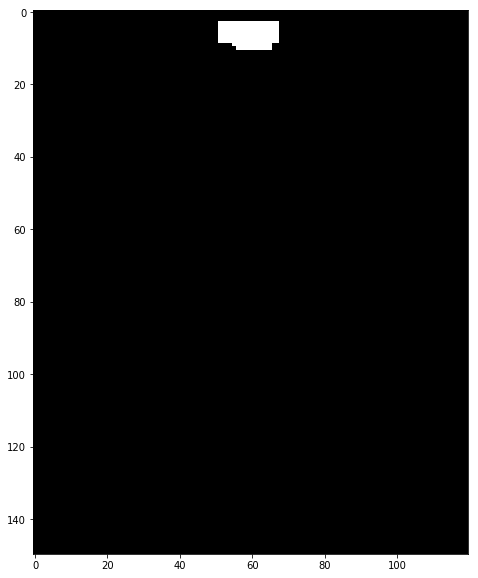

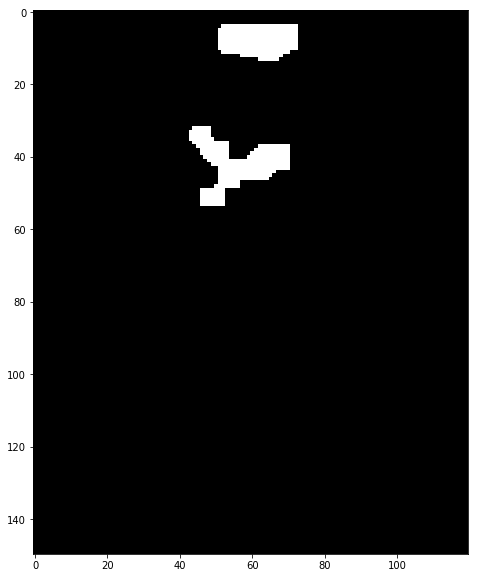

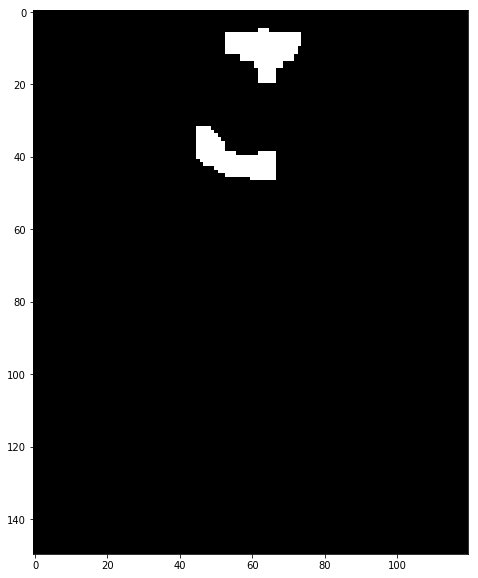

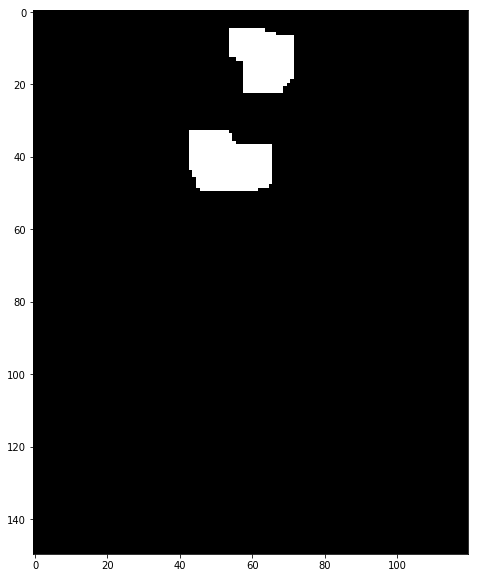

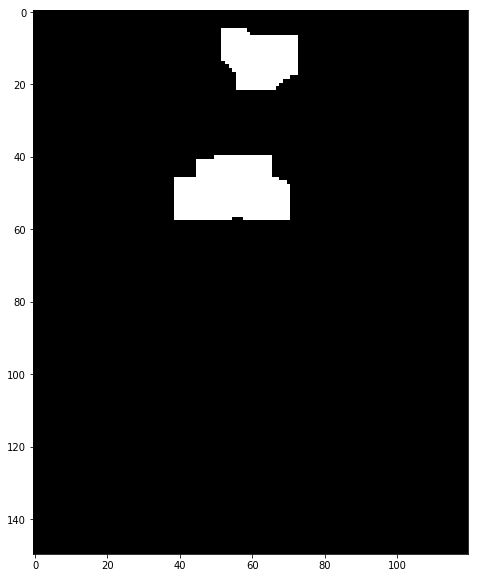

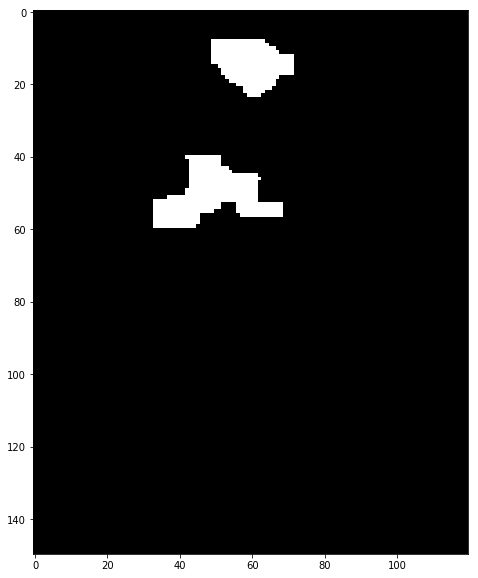

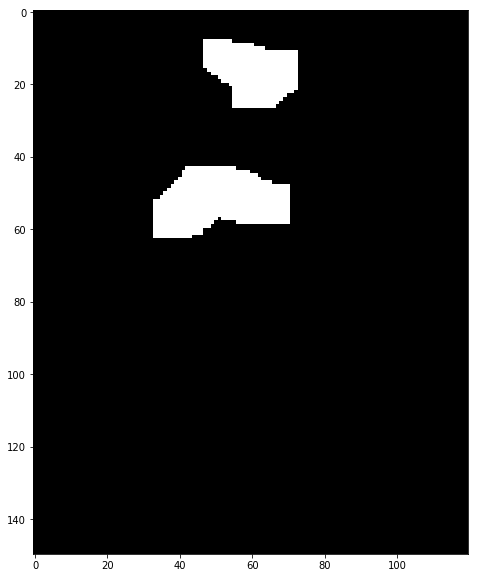

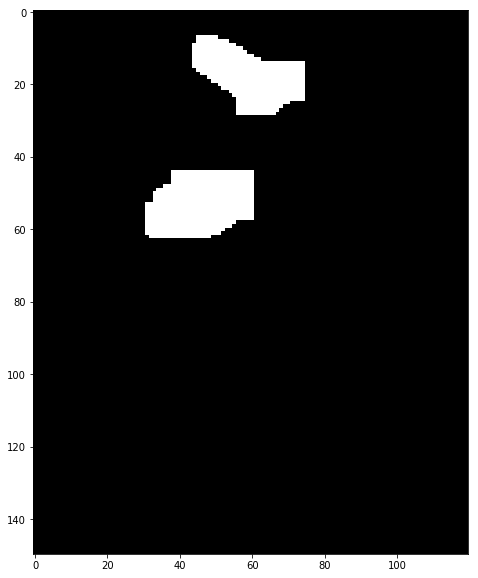

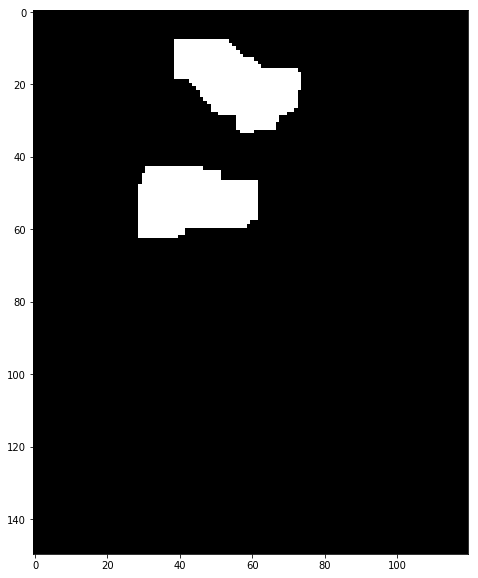

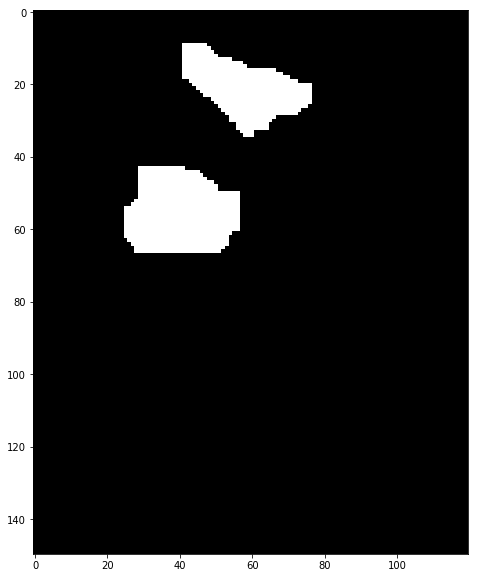

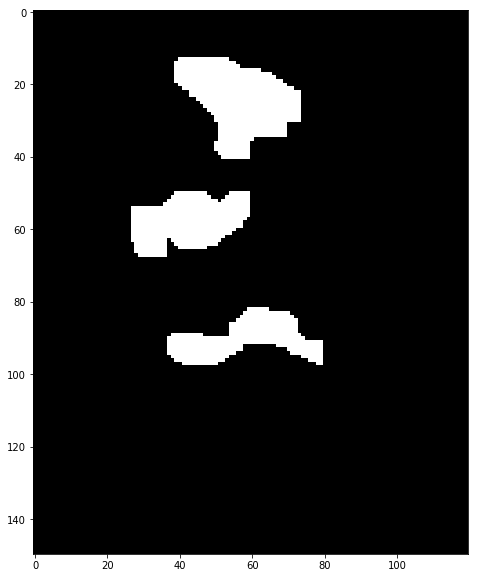

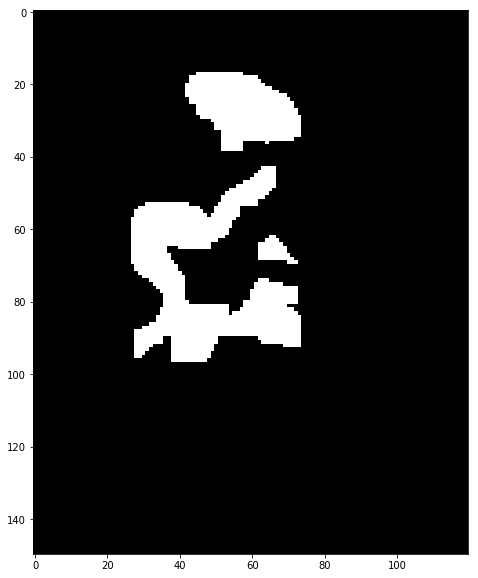

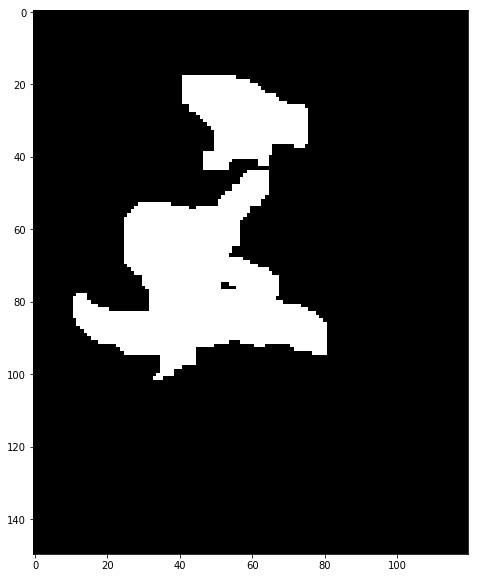

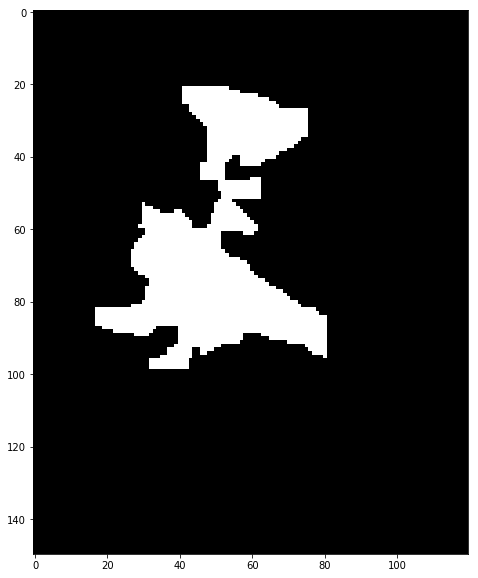

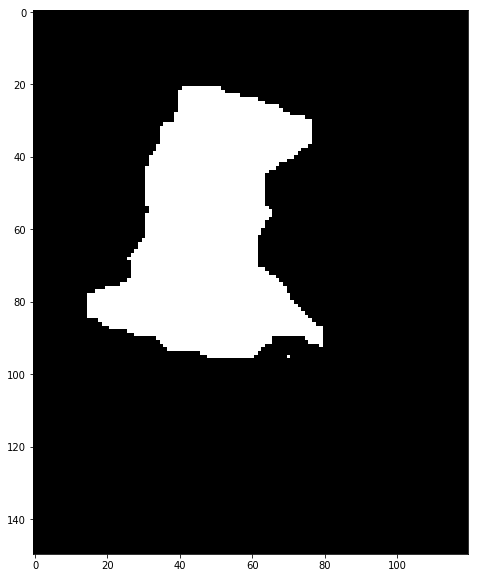

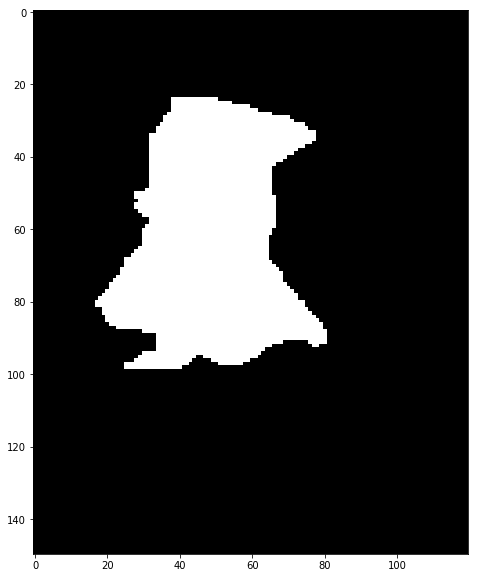

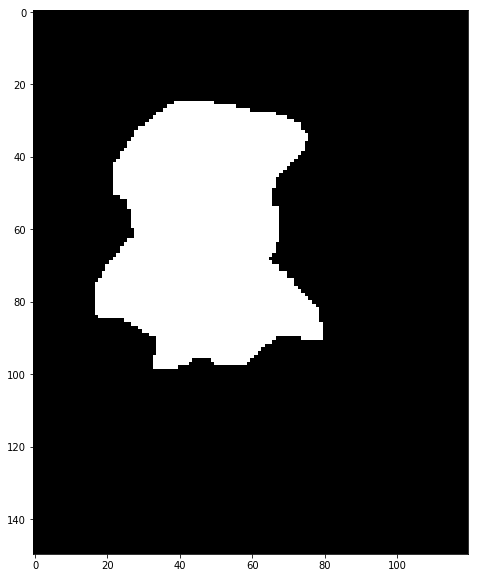

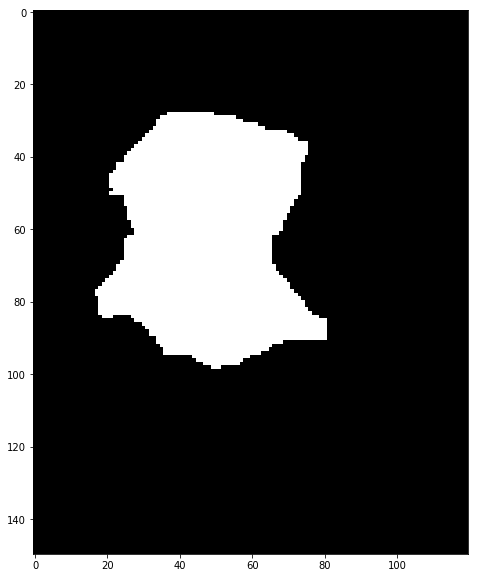

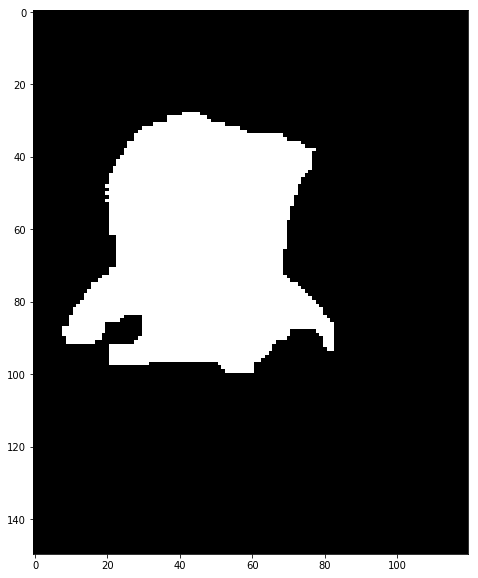

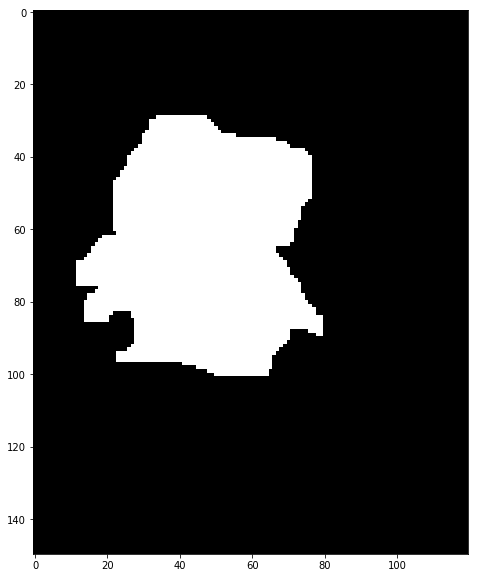

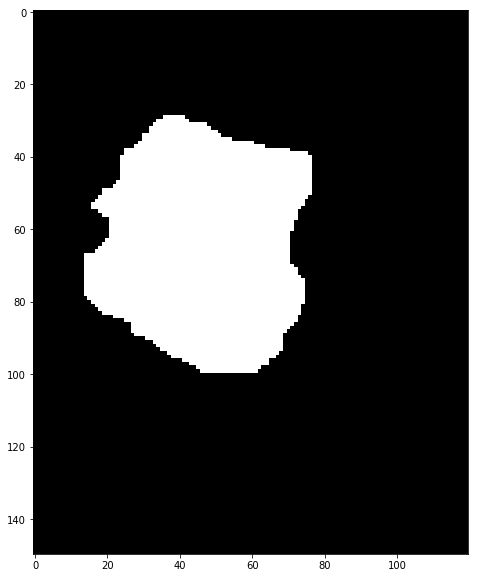

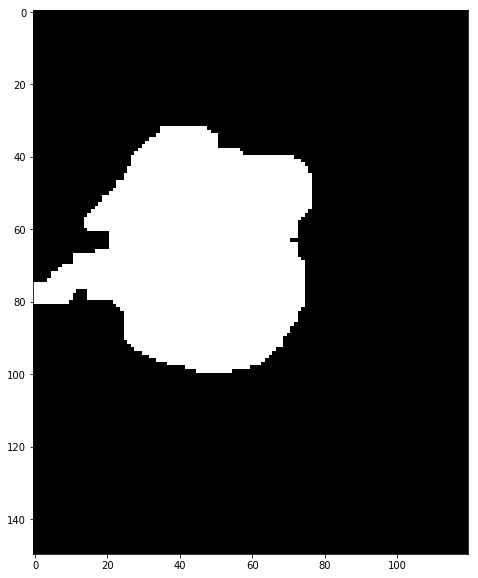

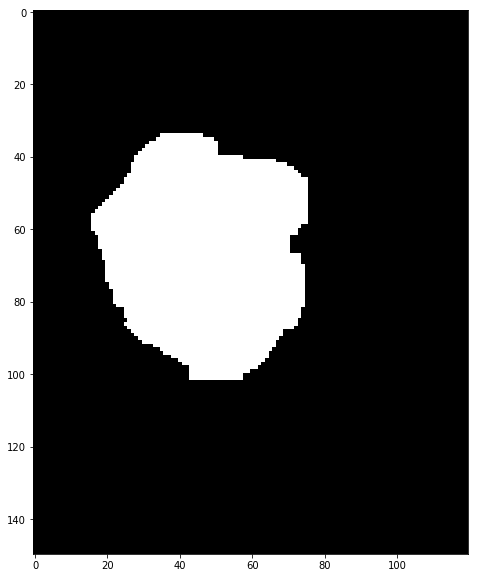

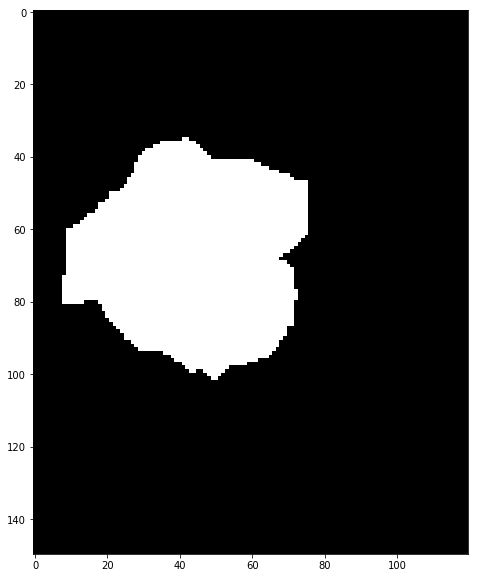

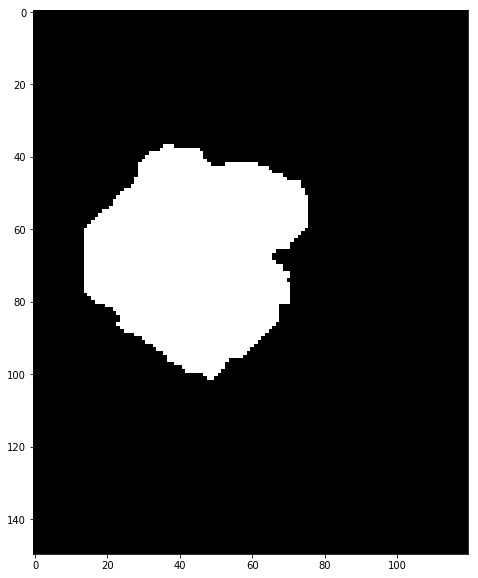

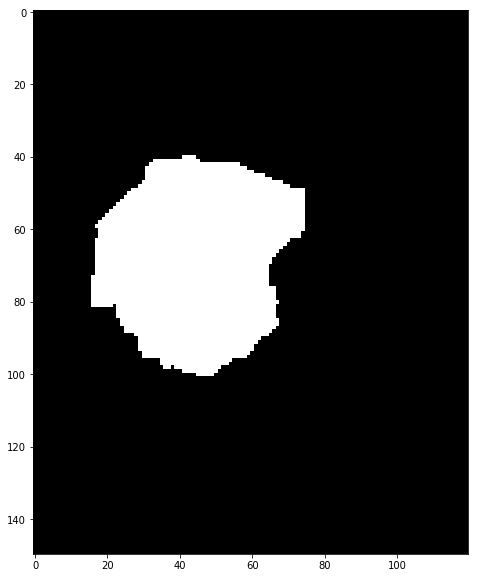

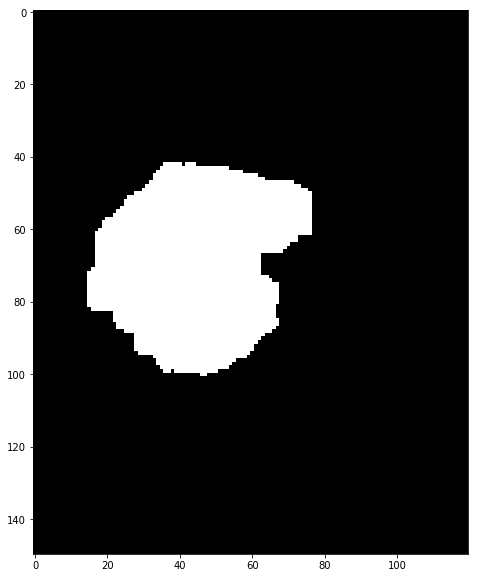

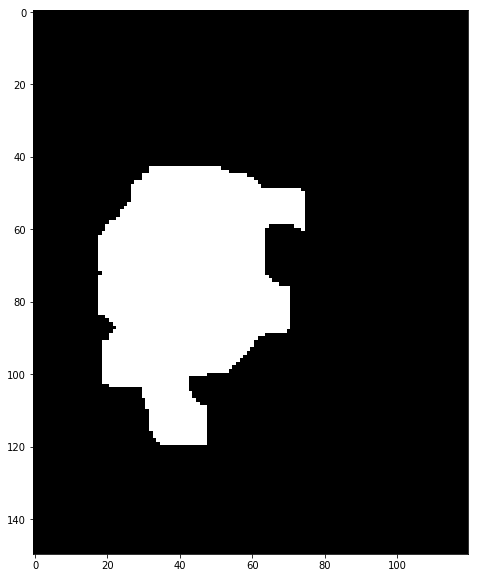

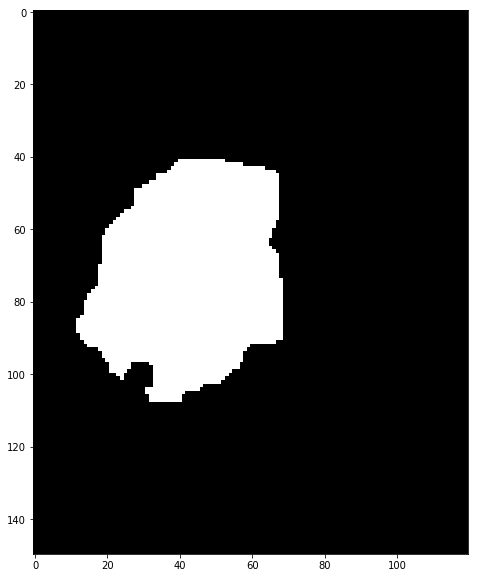

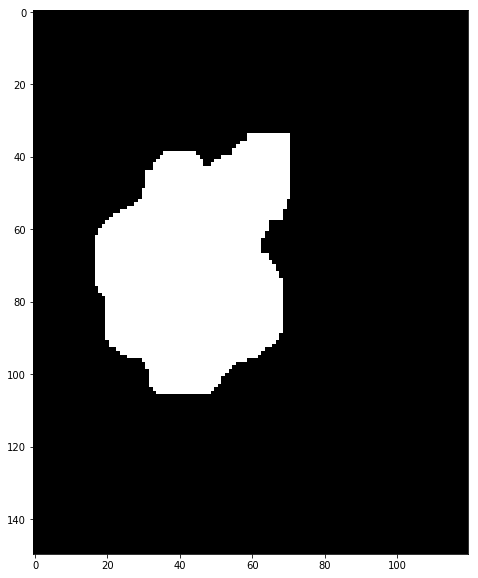

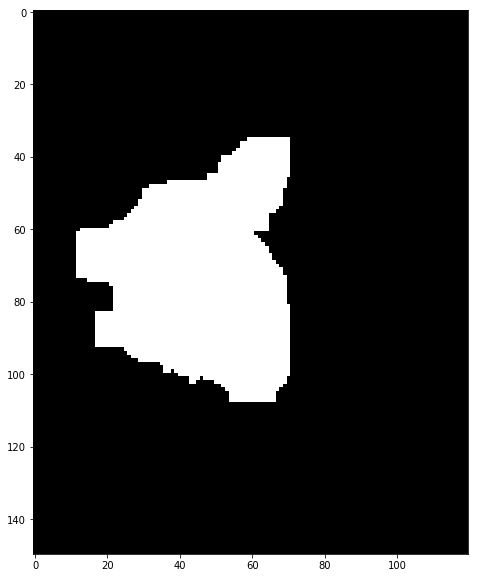

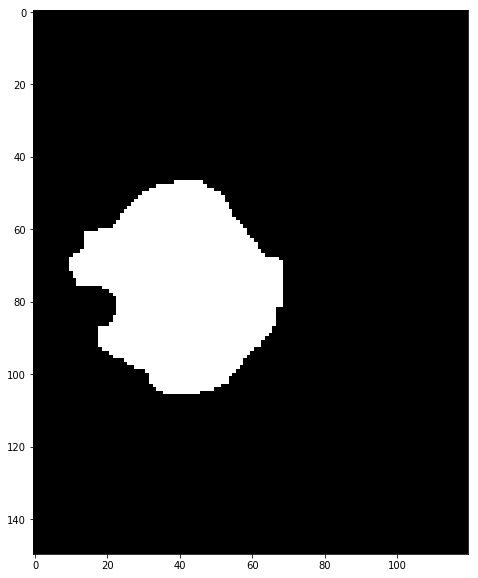

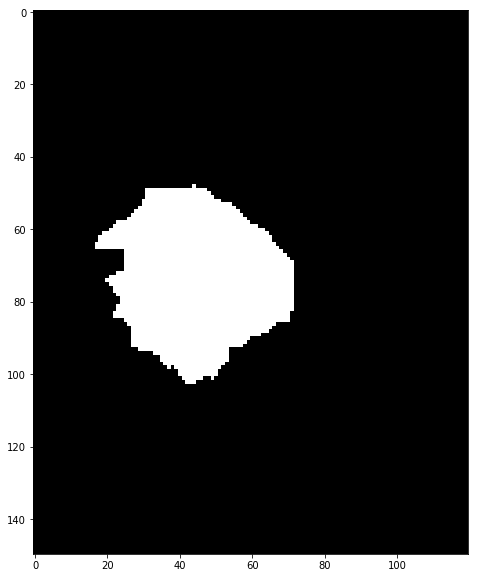

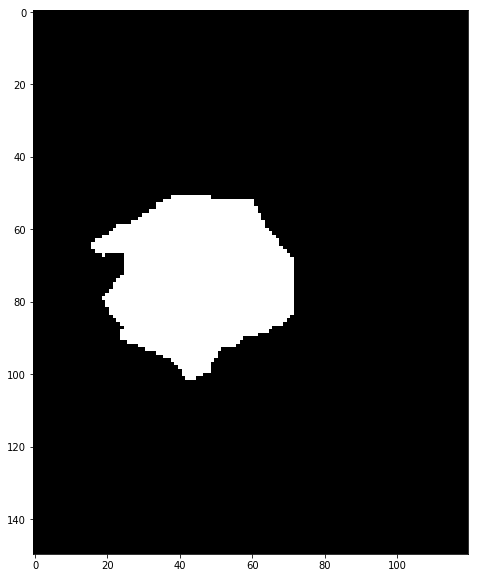

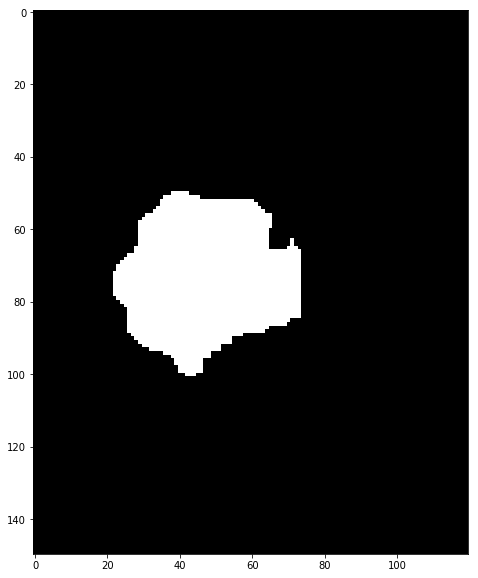

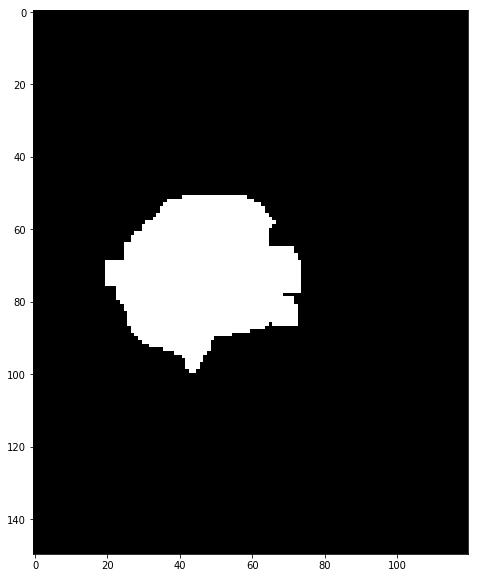

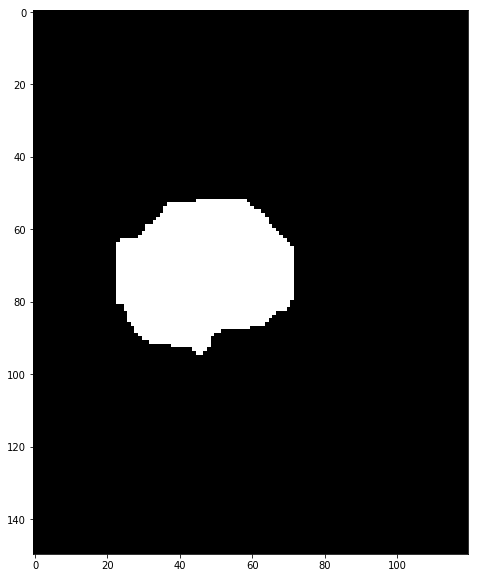

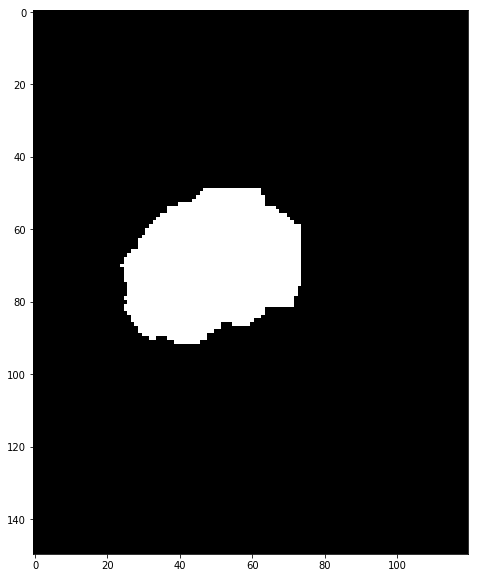

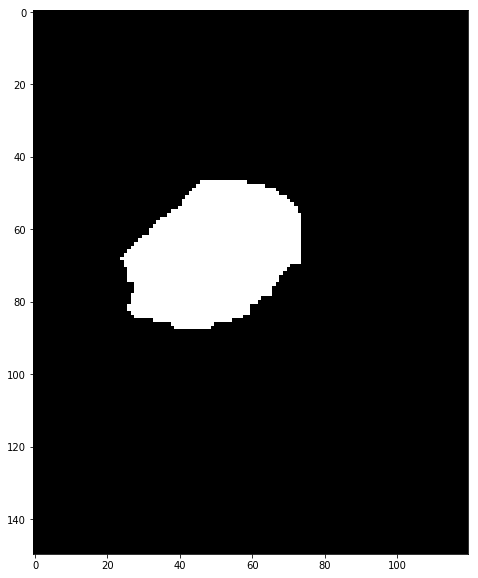

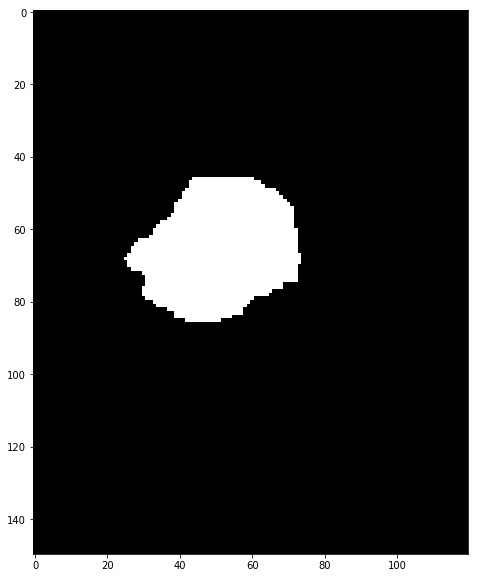

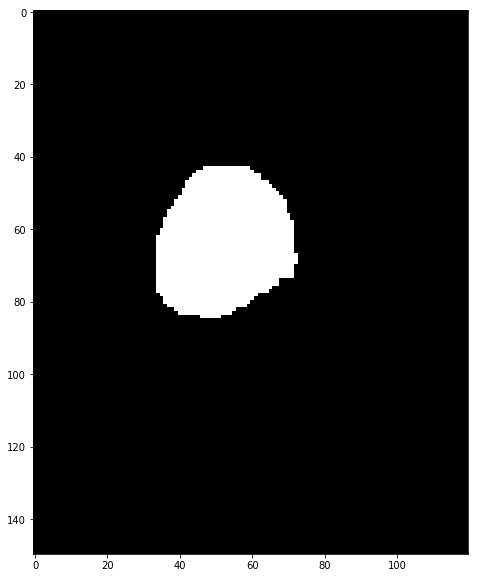

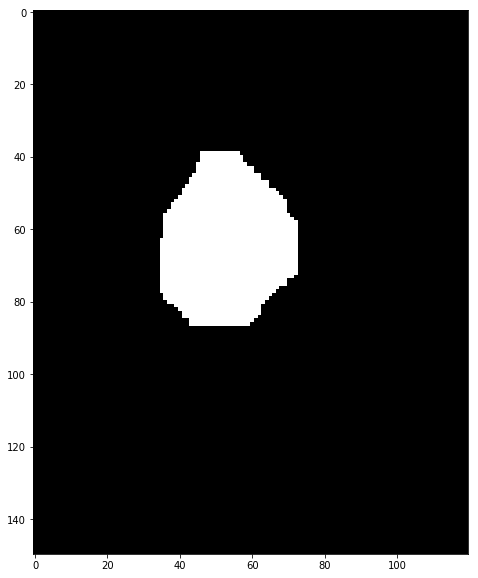

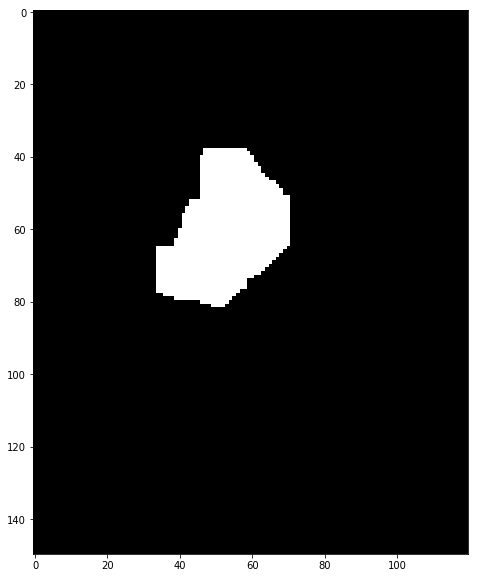

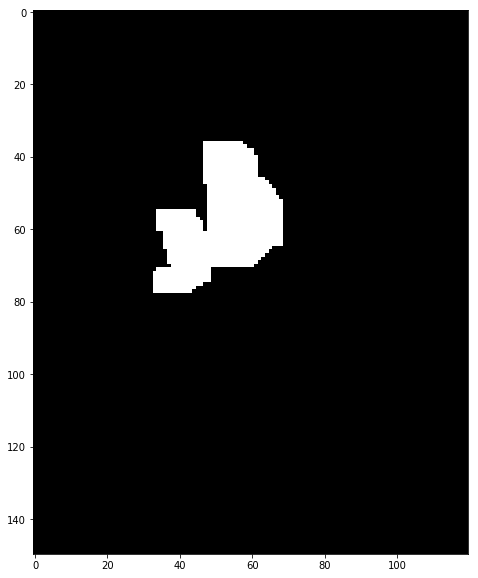

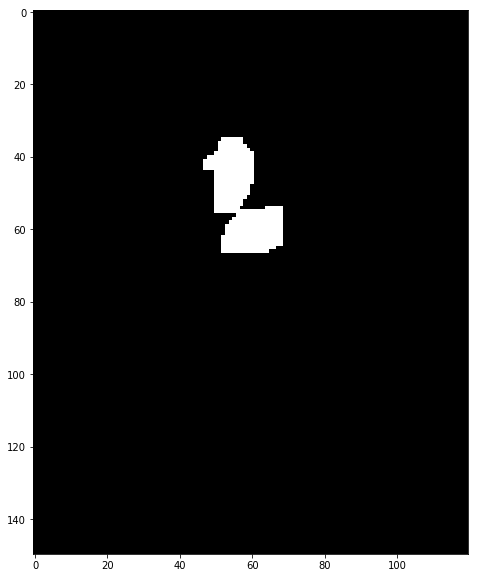

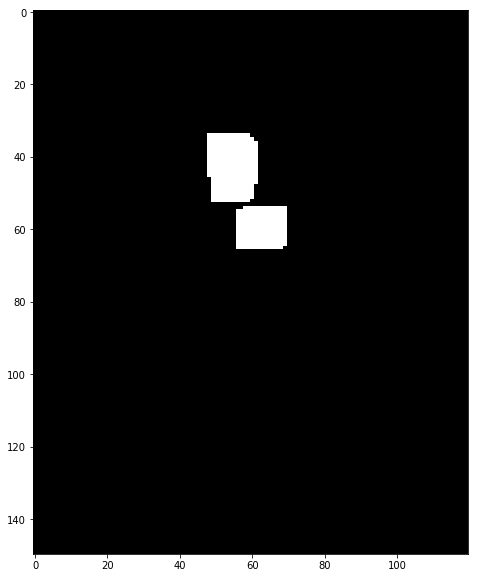

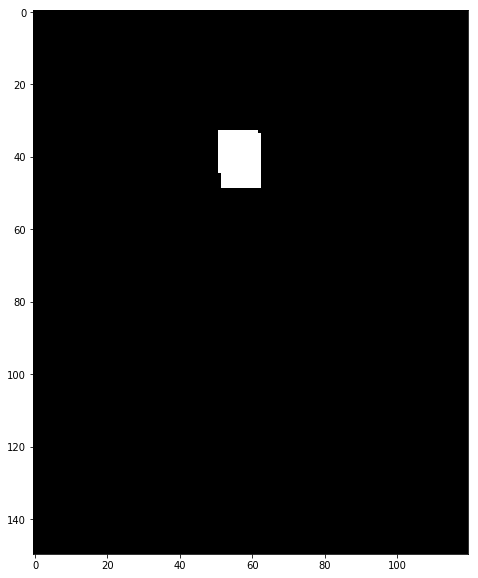

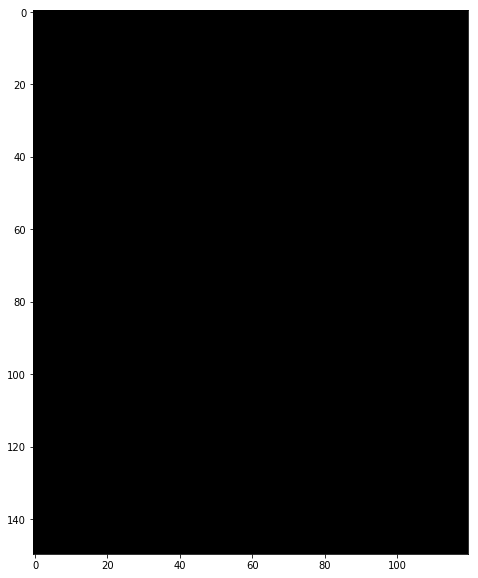

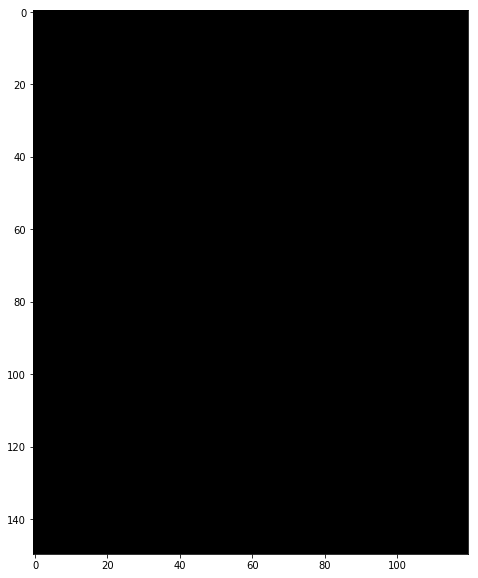

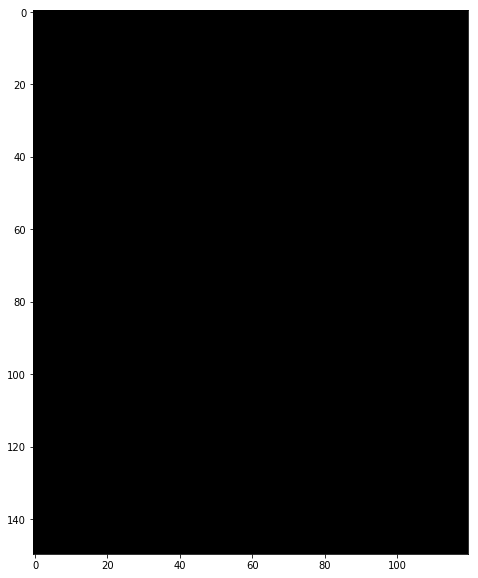

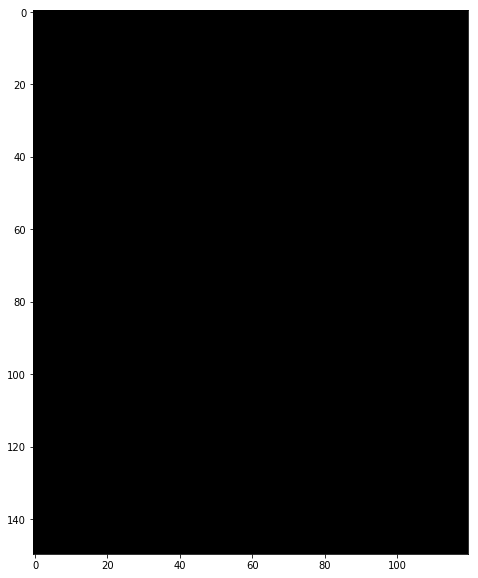

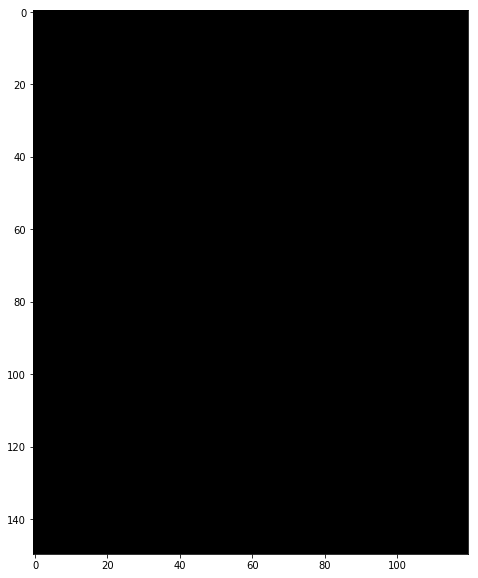

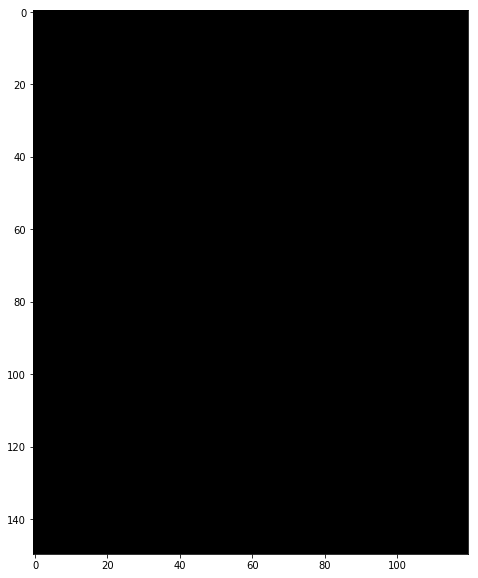

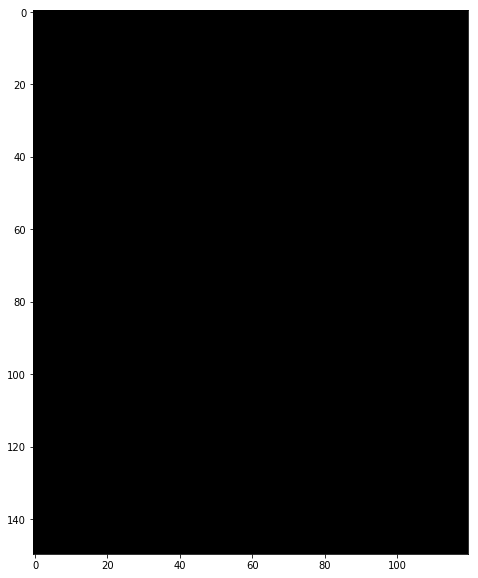

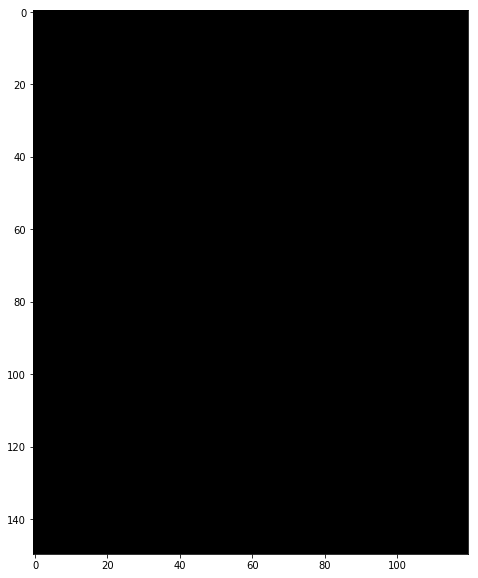

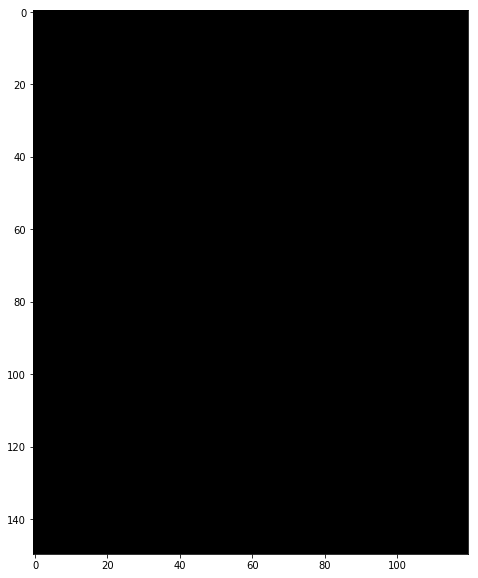

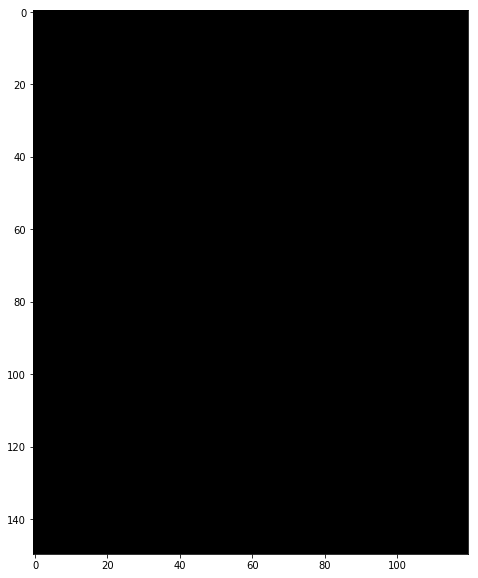

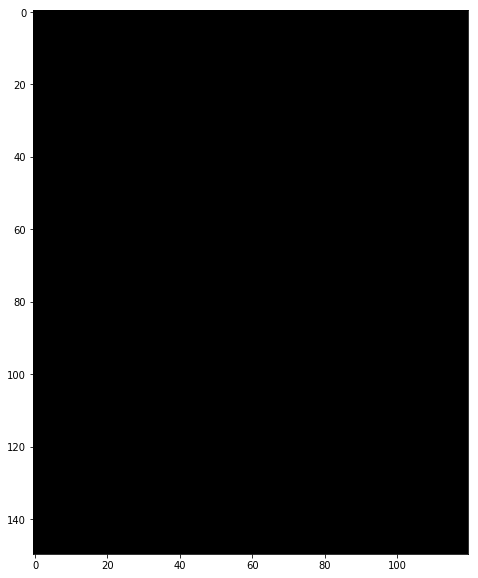

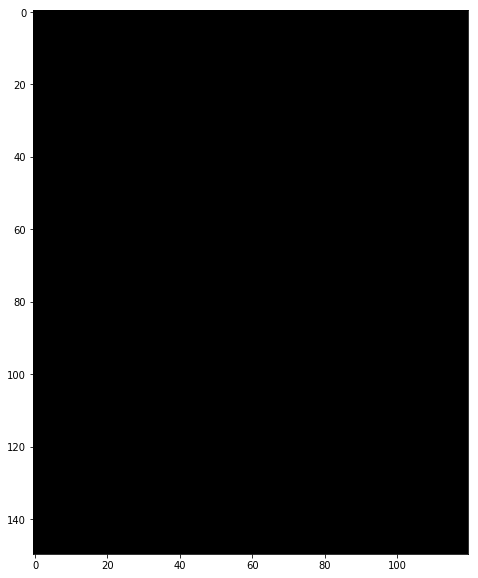

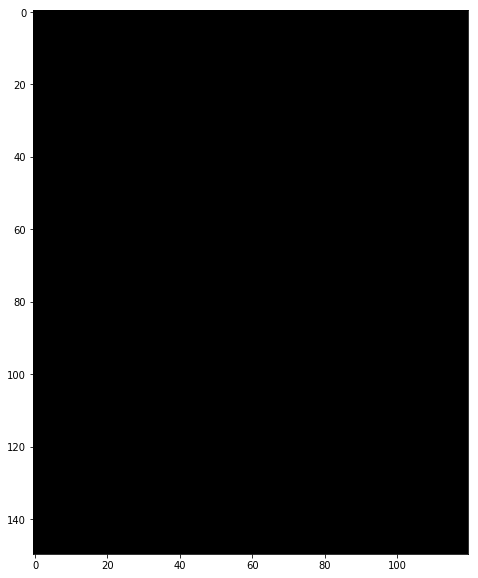

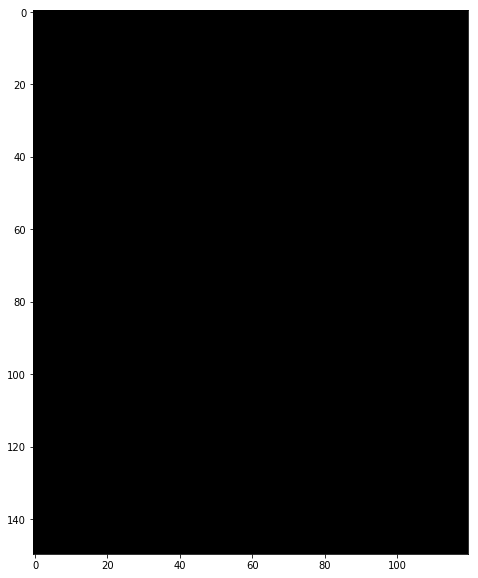

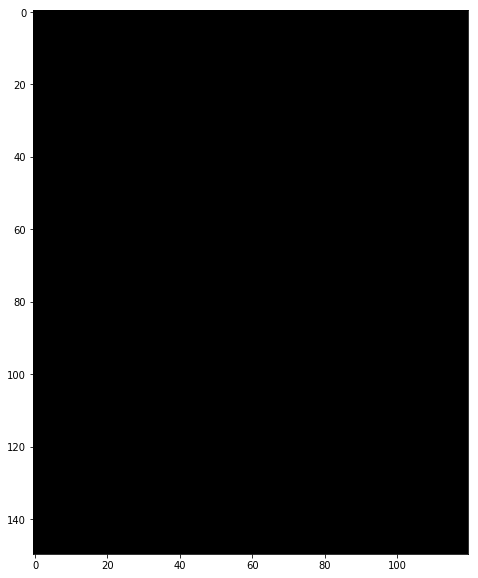

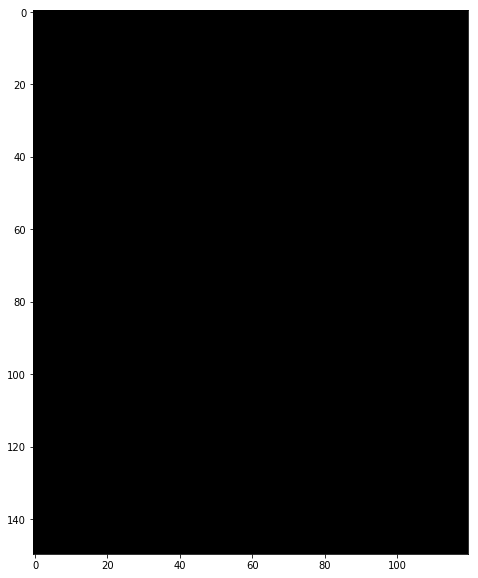

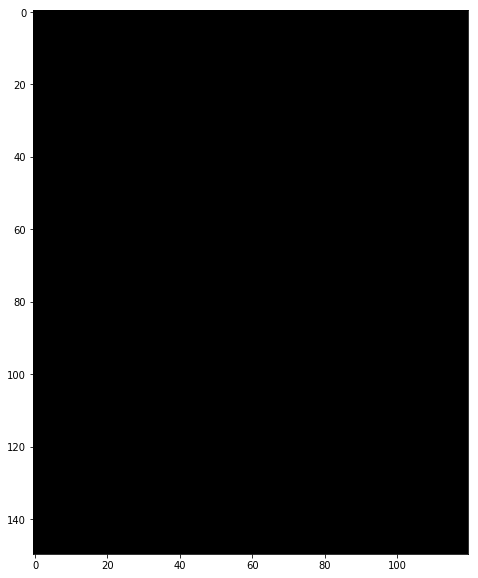

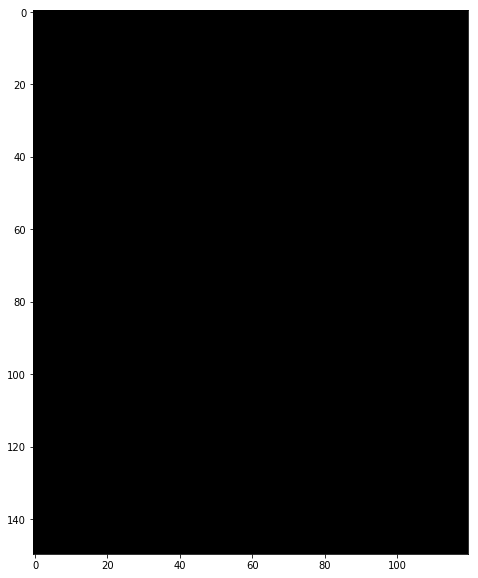

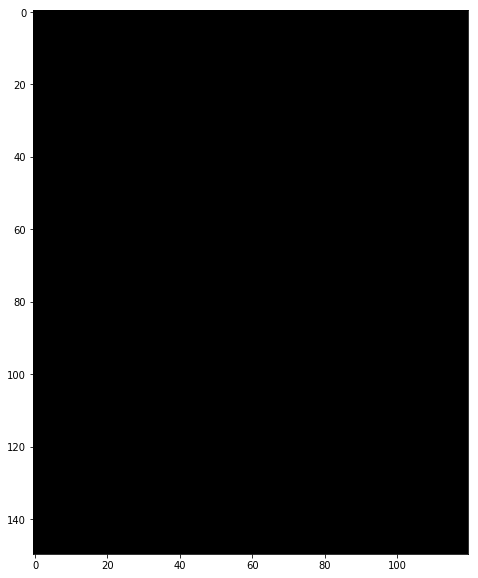

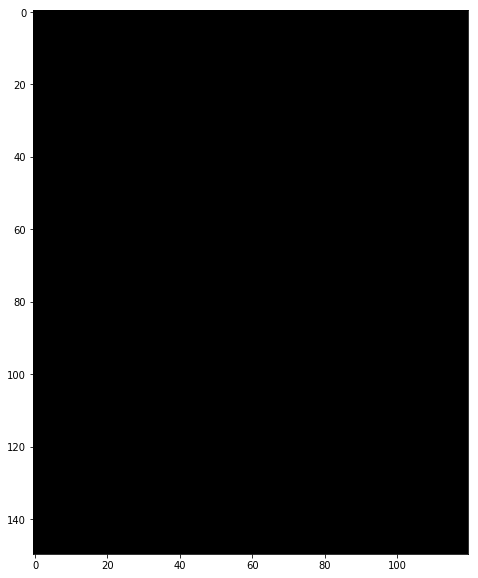

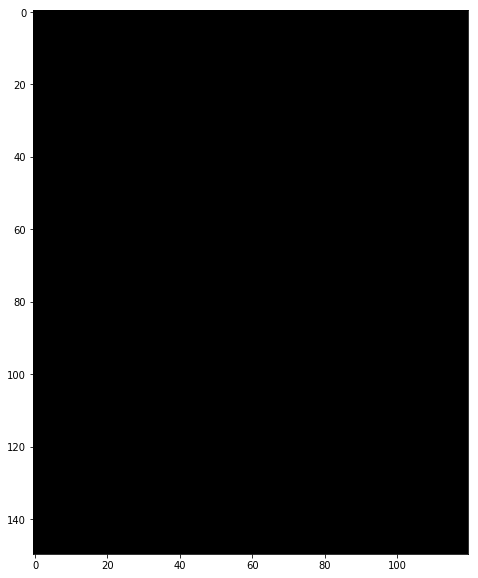

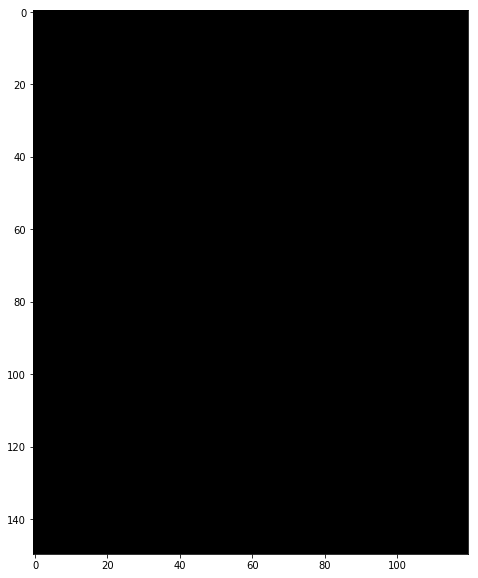

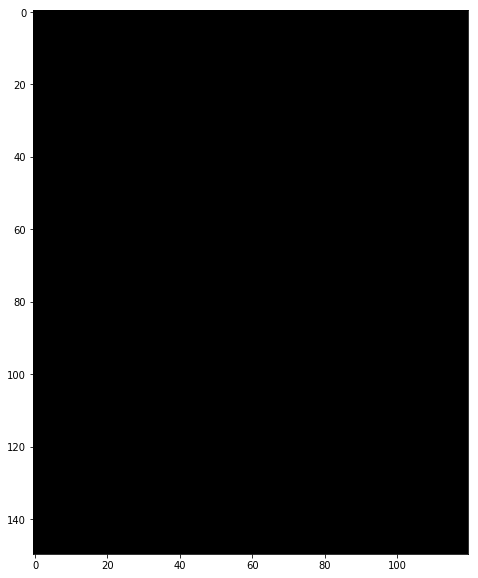

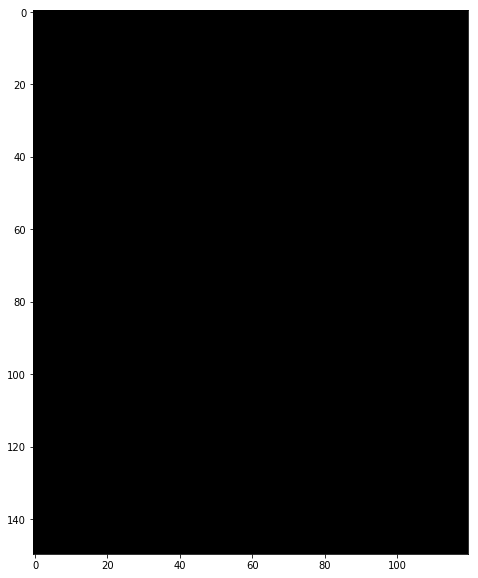

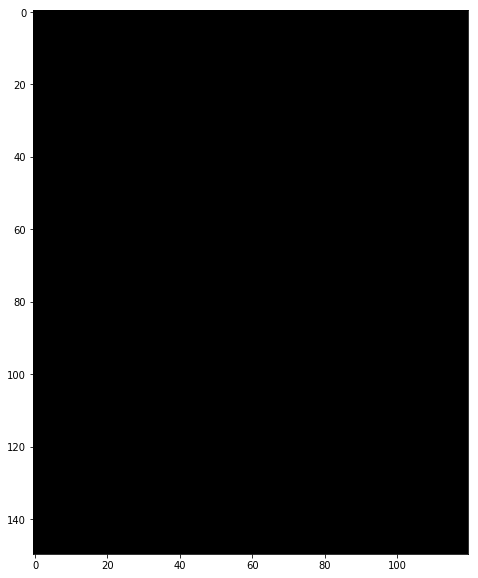

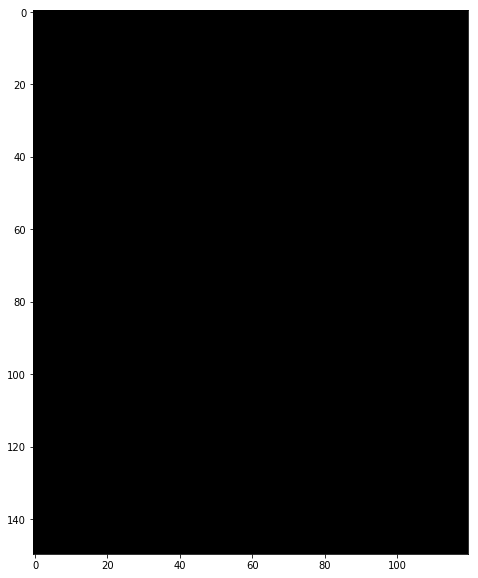

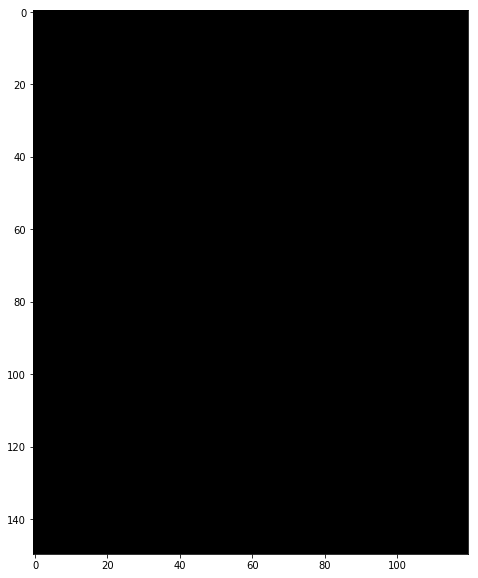

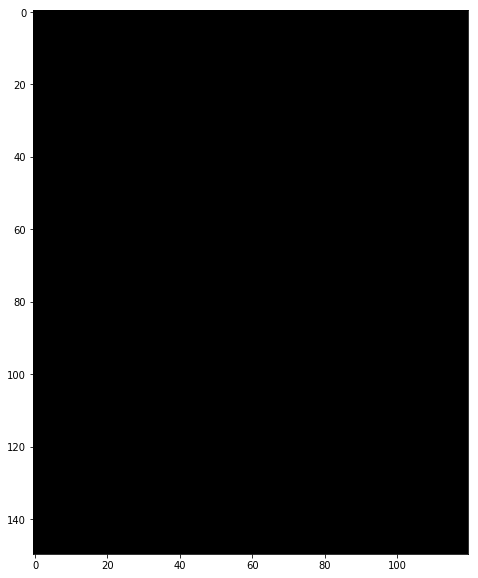

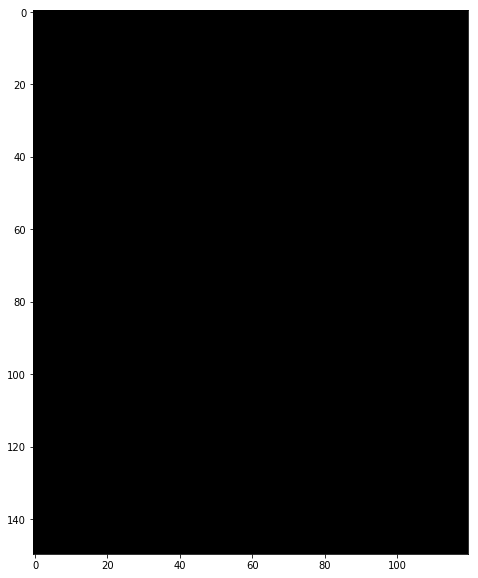

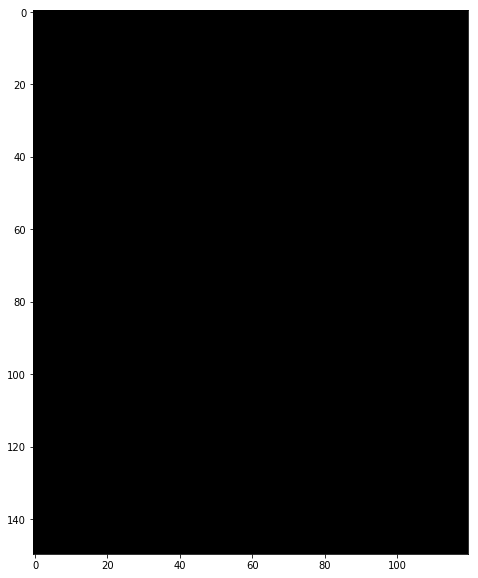

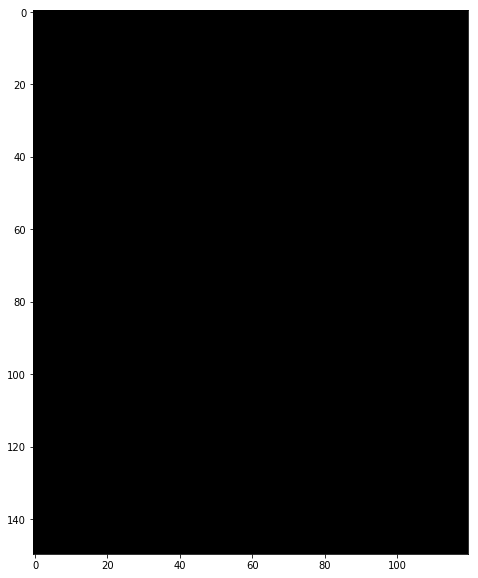

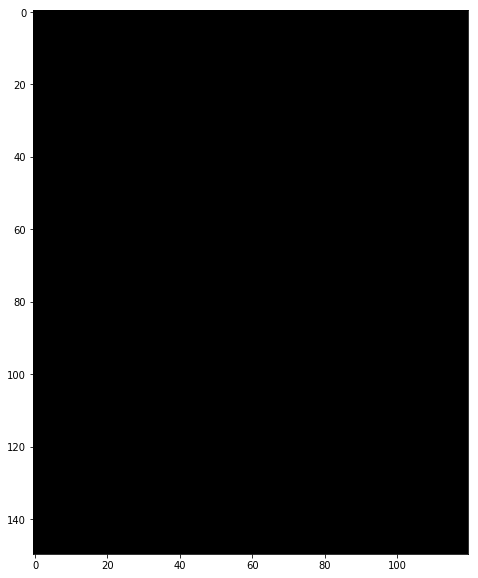

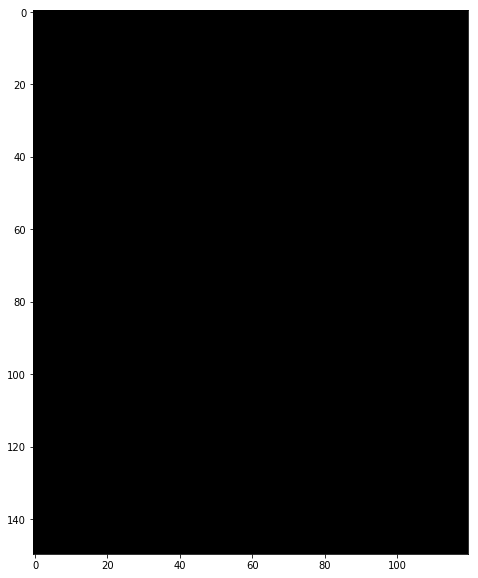

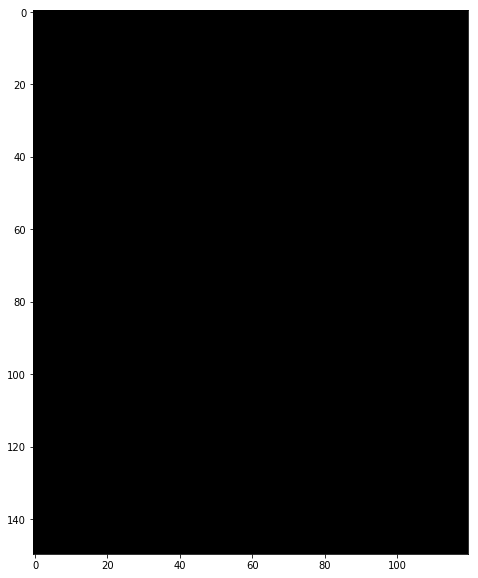

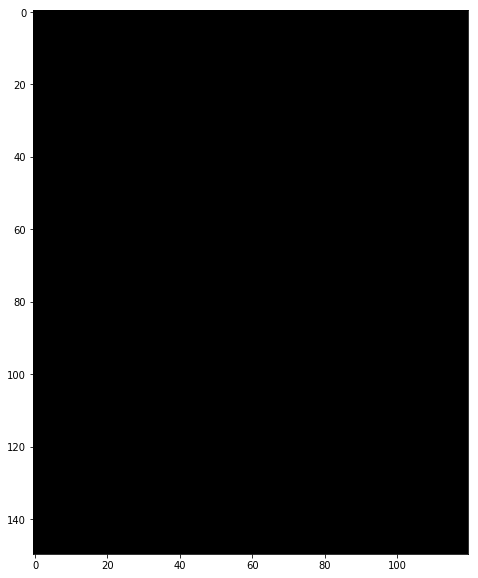

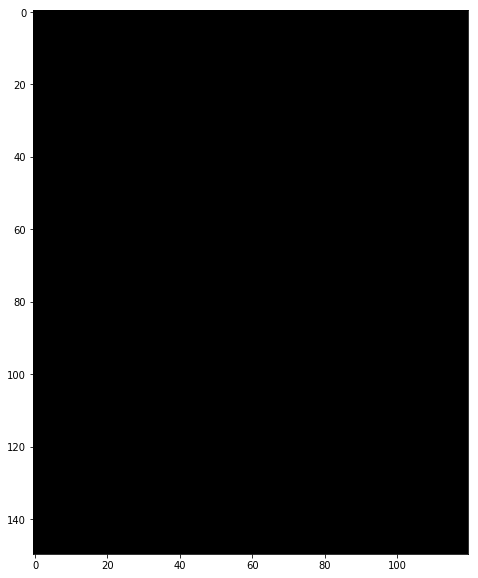

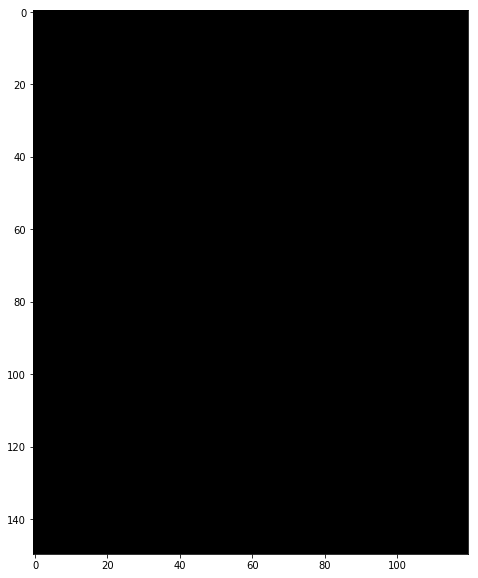

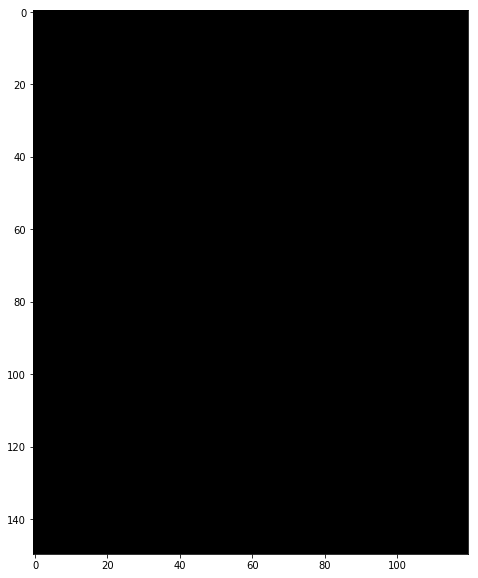

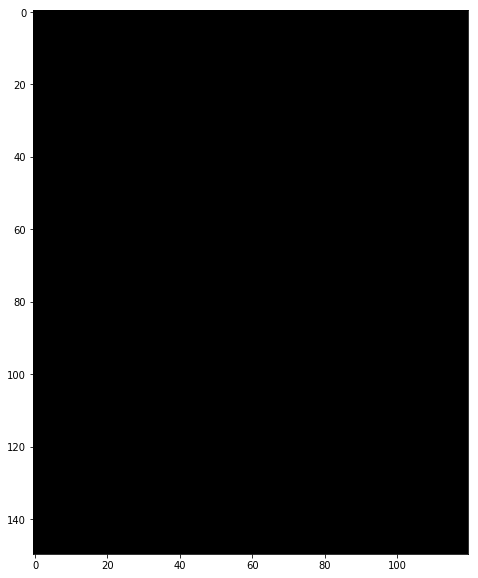

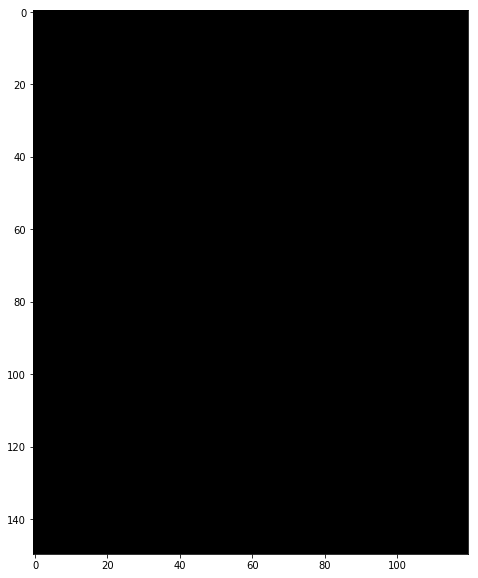

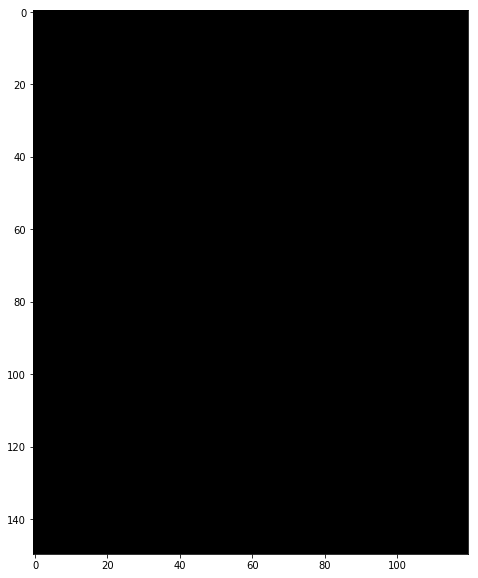

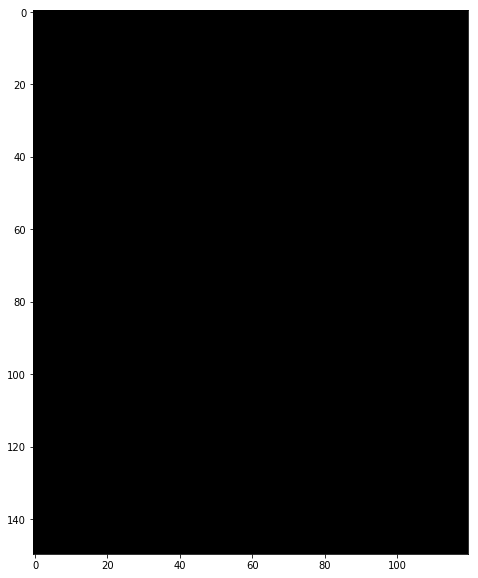

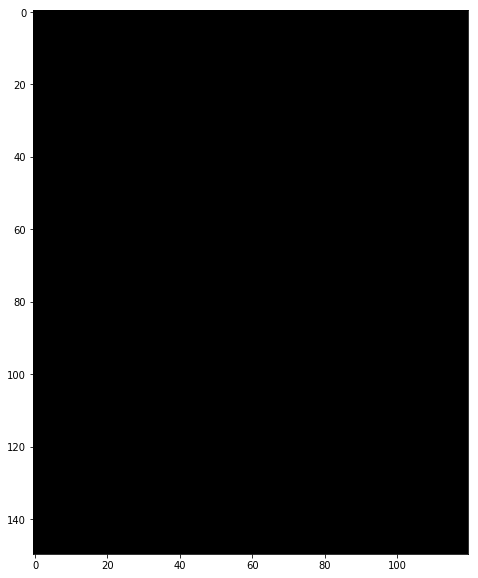

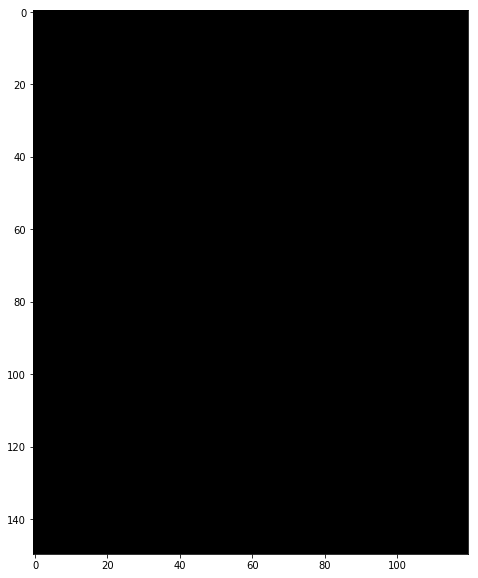

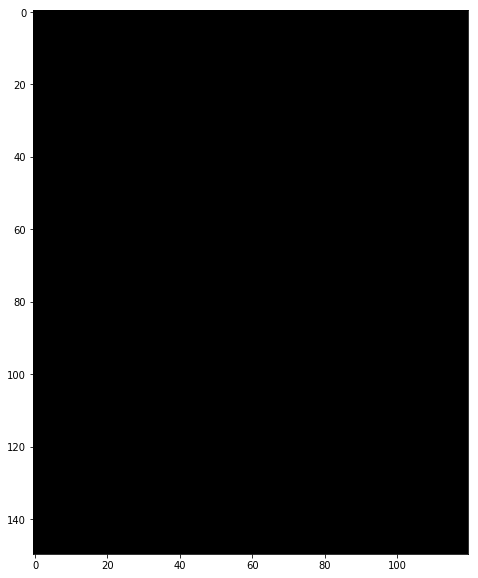

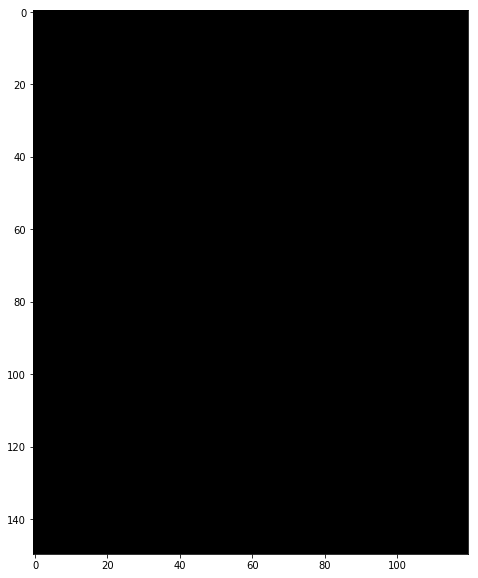

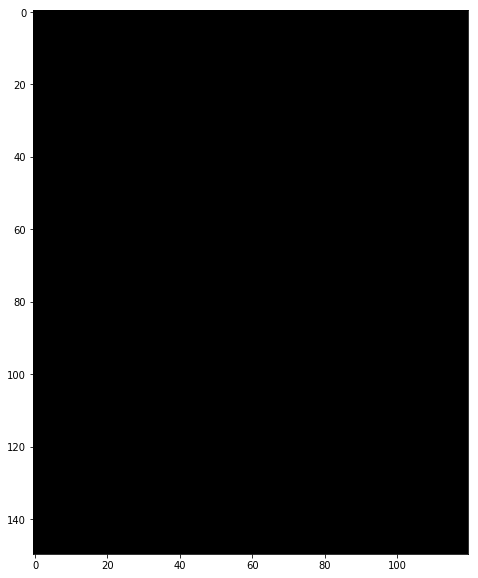

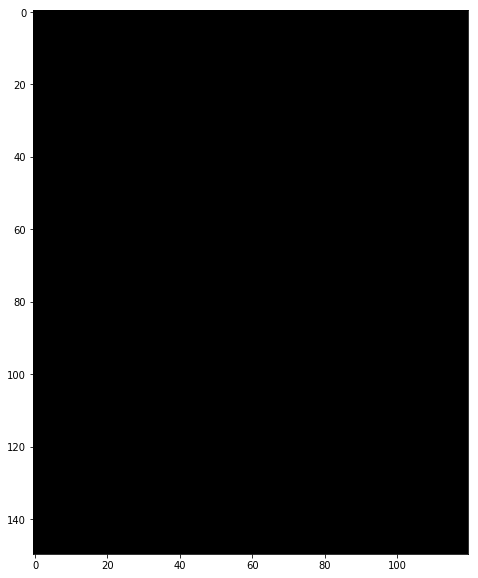

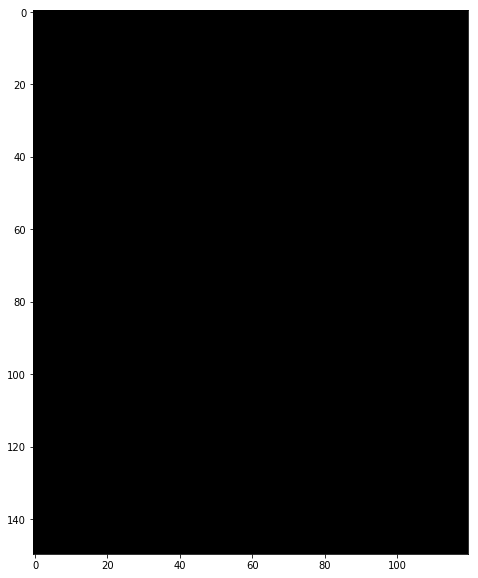

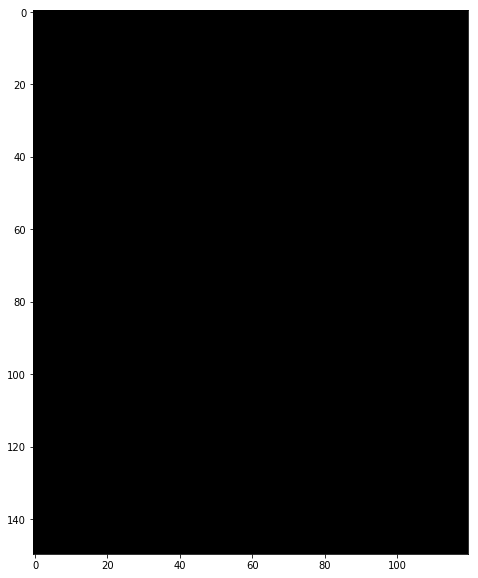

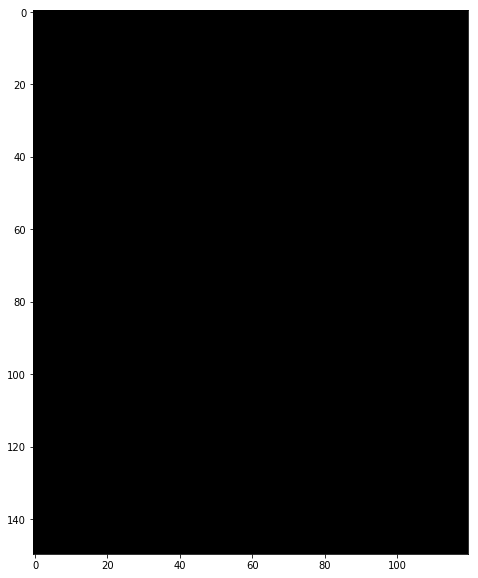

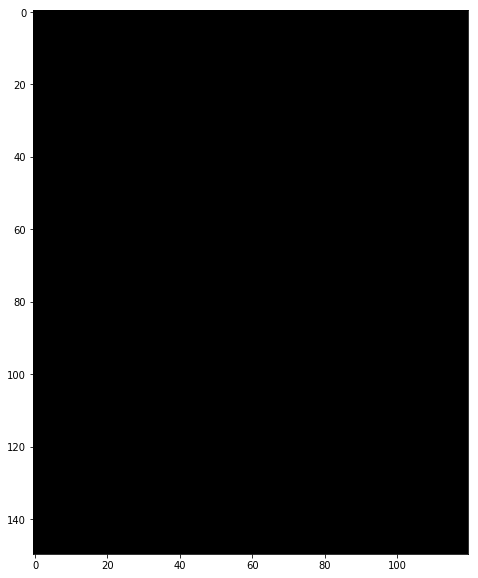

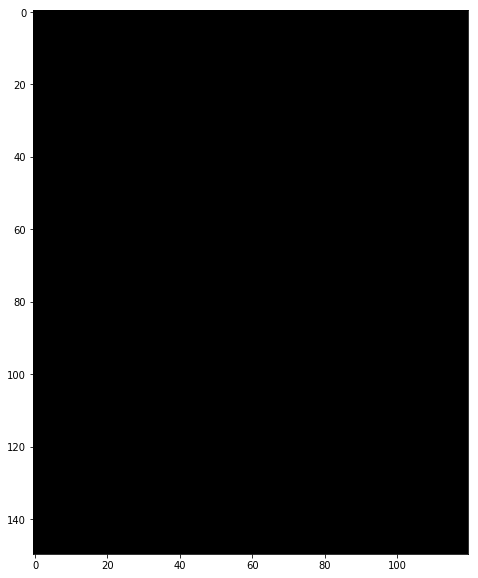

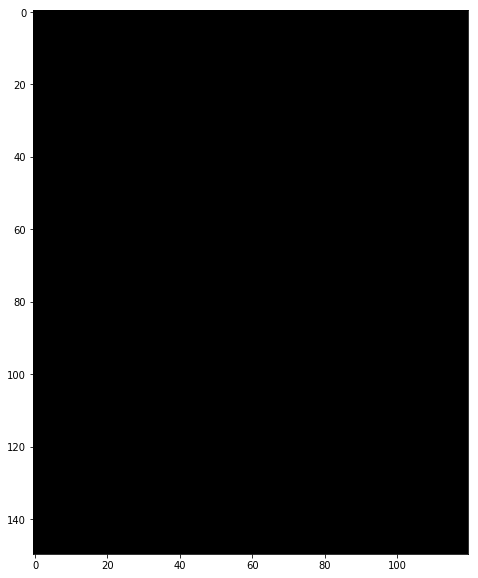

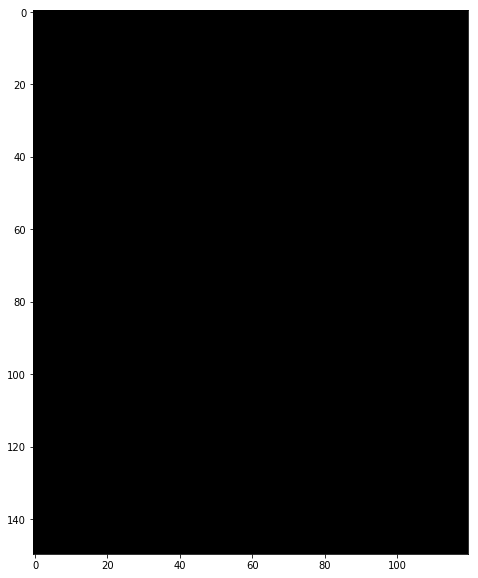

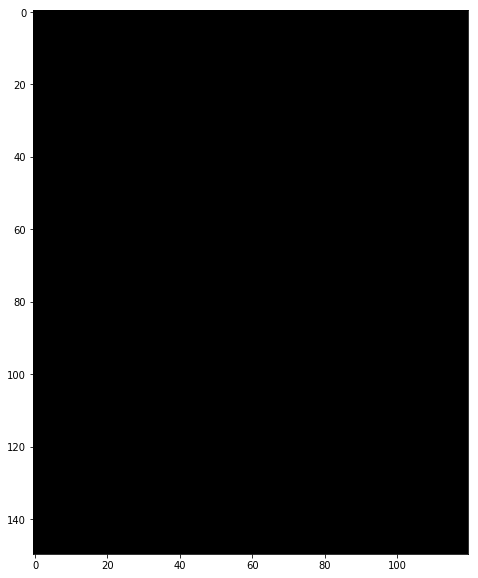

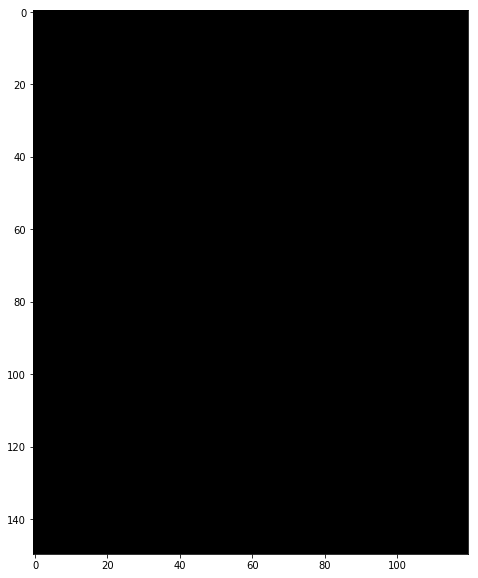

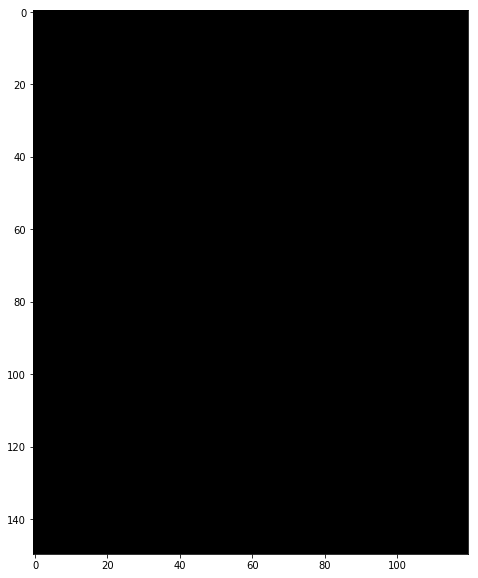

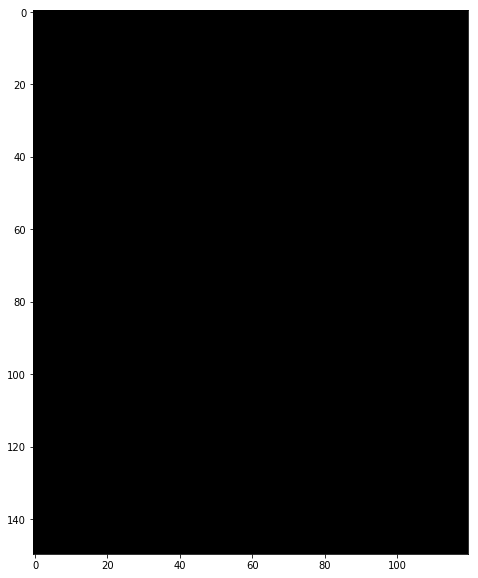

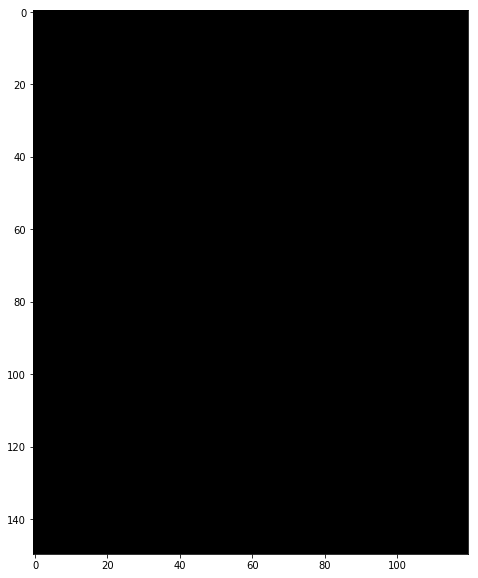

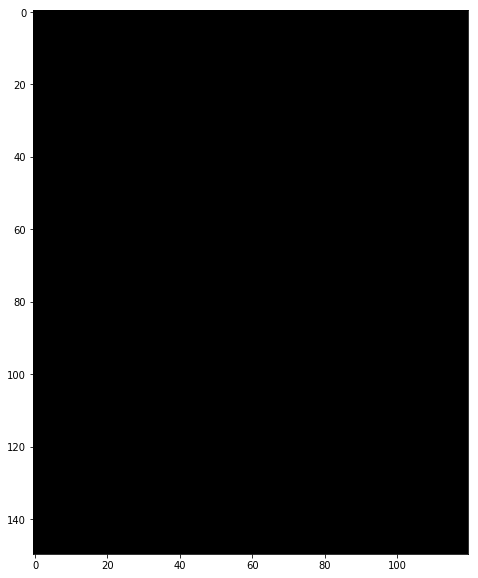

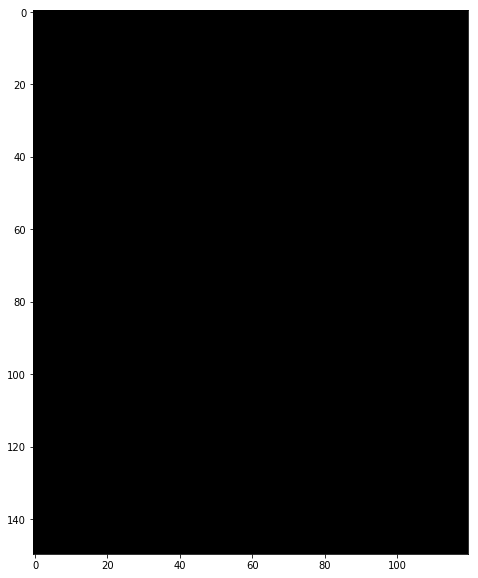

In [6]:
Max_tumor_shape = [111, 119, 149]

def crop_tumor (patient_file_name):
    patient = pickle.load(open(patient_file_name, 'rb'))
    img = patient['img']
    mask = patient['mask']
    print(mask.shape)
    
    del patient
    
    z_values, y_values, x_values = np.where(mask==1)
    
    z_tumor_begining = np.min(z_values)
    y_tumor_begining = np.min(y_values)
    x_tumor_begining = np.min(x_values)
    
    z_tumor_end = z_tumor_begining + int(Max_tumor_shape[0]) +1
    y_tumor_end = y_tumor_begining + int(Max_tumor_shape[2]) +1
    x_tumor_end = x_tumor_begining + int(Max_tumor_shape[1]) +1
    
    img = img[z_tumor_begining:z_tumor_end,
              y_tumor_begining:y_tumor_end,
              x_tumor_begining:x_tumor_end]
    
    mask = mask[z_tumor_begining:z_tumor_end,
                y_tumor_begining:y_tumor_end,
                x_tumor_begining:x_tumor_end]
    
    tumor = img*mask           ###Tune###
    
    #return tumor
    return mask

test = crop_tumor('R01-099.pickle')
print(test.shape)

for i in range(test.shape[0]):
    f, (ax) = plt.subplots(1, 1, figsize=(20,10),sharey=True)
    ax.grid(False)
    ax.imshow(test[i],'gray')
    plt.show()

In [10]:
"""Data constants"""

mean_img = get_mean_img(list_of_patients)

R01-001.pickle


R01-002.pickle


R01-003.pickle


R01-004.pickle


R01-005.pickle


R01-006.pickle


R01-007.pickle


R01-008.pickle


R01-010.pickle


R01-011.pickle


R01-012.pickle


R01-013.pickle


R01-014.pickle


R01-015.pickle


R01-016.pickle


R01-017.pickle


R01-018.pickle


R01-019.pickle


R01-020.pickle


R01-021.pickle


R01-022.pickle


R01-023.pickle


R01-024.pickle


R01-025.pickle


R01-026.pickle


R01-027.pickle


R01-028.pickle


R01-029.pickle


R01-030.pickle


R01-031.pickle


R01-032.pickle


R01-033.pickle


R01-034.pickle


R01-035.pickle


R01-036.pickle


R01-037.pickle


R01-038.pickle


R01-039.pickle


R01-040.pickle


R01-041.pickle


R01-042.pickle


R01-043.pickle


R01-044.pickle


R01-045.pickle


R01-046.pickle


R01-047.pickle


R01-048.pickle


R01-049.pickle


R01-050.pickle


R01-051.pickle


R01-052.pickle


R01-053.pickle


R01-054.pickle


R01-055.pickle


R01-056.pickle


R01-057.pickle


R01-058.pickle


R01-059.pickle


R01-060.pickle

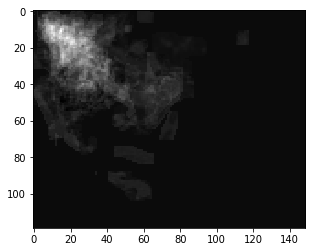

In [20]:
for i in range(mean_img.shape[0]):
    f, (ax) = plt.subplots(1, 1, figsize=(20,10),sharey=True)
    ax.grid(False)
    ax.imshow(mean_img[i],'gray')
    plt.show()

In [31]:
""" Testing cell """
patient_file_name = 'R01-001.pickle'
patient = pickle.load(open(patient_file_name, 'rb'))
V1 = 1307.1516802137207
A1 = 44.91590064885712
V = get_tumor_volume(patient)
A = get_surface_area(patient)
print(V==V1, A==A1)

True True


In [23]:
test = 'R01-006.pickle'
p = pickle.load(open(test, 'rb'))
t = crop_tumor(p)

for feature in Statistcal_features:
    print(feature.__name__, ": ", feature(t))

Energy :  -3325265
Entropy :  41065128.75088828
Kurtosis :  0.44704772825074635
Maximum :  1112
Mean :  3.045901182892892
Mean_abs_dev :  -1.9821527530439198e-08
Median :  0.0
Minimum :  0
Range :  1112
RMS :  nan
Skewness :  17.715377732715055
std :  52.22957476728697
Uniformity :  3845888198861
Variance :  -1.0071197948539838e-14


/home/ghadeer/.local/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt


In [39]:
""" Testing cell """

patient_file_name = 'R01-001.pickle'
patient = pickle.load(open(patient_file_name, 'rb'))

energy = energy(patient)
entropy = entropy(patient)

print(energy, entropy)

89420717 26672920.800039493


In [93]:
for tag in test['tags'].keys():
    print(tag, ": ", test['tags'][tag])

AccessionNumber :  3077581421648539
AcquisitionNumber :  2
BitsAllocated :  16
BitsStored :  16
BodyPartExamined :  CHEST
Columns :  512
ContentDate :  20190119
ContentTime :  151154.225000
ConvolutionKernel :  B45f
DataCollectionDiameter :  500
DateOfLastCalibration :  19900906
DeidentificationMethod :  Per DICOM PS 3.15 AnnexE. Details in 0012,0064
DeidentificationMethodCodeSequence :  [(0008, 0100) Code Value                          SH: '113100'
(0008, 0102) Coding Scheme Designator            SH: 'DCM'
(0008, 0104) Code Meaning                        LO: 'Basic Application Confidentiality Profile'(0008, 0100) Code Value                          SH: '113101'
(0008, 0102) Coding Scheme Designator            SH: 'DCM'
(0008, 0104) Code Meaning                        LO: 'Clean Pixel Data Option'(0008, 0100) Code Value                          SH: '113104'
(0008, 0102) Coding Scheme Designator            SH: 'DCM'
(0008, 0104) Code Meaning                        LO: 'Clean Structured 

(100, 1)
(1, 100)
(216, 2)


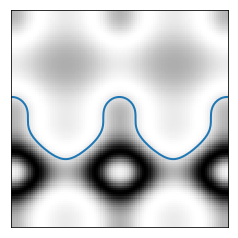

In [30]:
from skimage import measure
# Construct some test data
x, y = np.ogrid[-np.pi:np.pi:100j, -np.pi:np.pi:100j]
print(x.shape)
print(y.shape)
r = np.sin(np.exp((np.sin(x)**3 + np.cos(y)**2)))

# Find contours at a constant value of 0.8
contours = measure.find_contours(r, 0.8)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(r, interpolation='nearest', cmap=plt.cm.gray)

contour = contours[5]
print(contour.shape)
ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

(60,)
(60,)
(60, 2)
0


IndexError: list index out of range

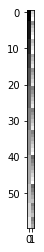

In [46]:
# patient_file_name = 'R01-001.pickle'
# patient = pickle.load(open(patient_file_name, 'rb'))

tumor = crop_tumor('R01-001.pickle')
x, y = np.where(tumor[0]>0)
# x = x.reshape(len(x), 1)
# y = y.reshape(1, len(y))
print(x.shape)
print(y.shape)
points = [a for a in zip(x,y)]
points = np.array(points)
print(points.shape)
# r = np.sin(np.exp((np.sin(x)**3 + np.cos(y)**2)))
# print(r.shape)

# Find contours at a constant value of 0.8
contours = measure.find_contours(points, 0.0001)
print(len(contours))

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(points, interpolation='nearest', cmap=plt.cm.gray)

contour = contours[0]
print(contour.shape)
ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

<class 'numpy.ndarray'>
72


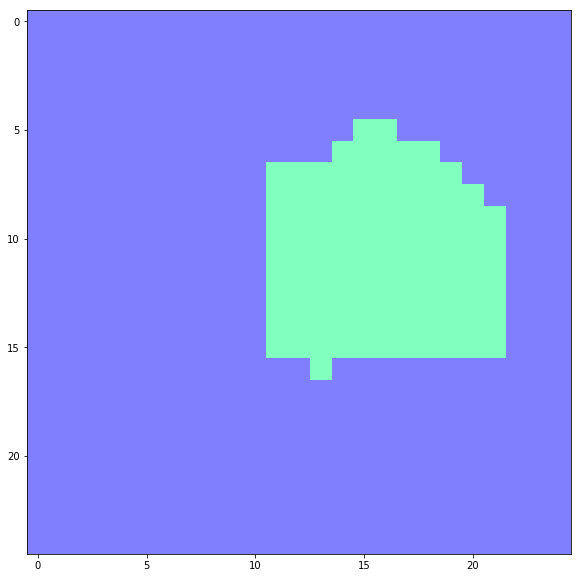

In [10]:
import skimage.filters.rank
import skimage.morphology
import skimage.io

tumor = crop_tumor('R01-001.pickle')
img = tumor[15]
#print(tumor[0].shape)
# selem = np.ones((3,3))
selem = skimage.morphology.disk(1)
# selem[1][1]=0

print(type(selem))

black_white_edges = (skimage.filters.rank.minimum(img, selem) == 0) & (skimage.filters.rank.maximum(img, selem) == 1)
print(np.count_nonzero(black_white_edges))

f, (ax) = plt.subplots(1, 1, figsize=(20,10),sharey=True)
ax.grid(False)
#ax.imshow(black_white_edges[:25, :25], 'pink')
ax.imshow(img[:25, :25],'winter', alpha = 0.5)
plt.show()

# The edges are doubled !!

In [2]:
### This cell should be deleted ###

import numpy as np
import pandas as pd
import pickle
import glob
import matplotlib.pyplot as plt

Max_tumor_shape = [111, 119, 149]

def crop_tumor (patient_file_name):
    patient = pickle.load(open(patient_file_name, 'rb'))
    img = patient['img']
    mask = patient['mask']
    
    del patient
    
    z_values, y_values, x_values = np.where(mask==1)
    
    z_tumor_begining = np.min(z_values)
    y_tumor_begining = np.min(y_values)
    x_tumor_begining = np.min(x_values)
    
    z_tumor_end = z_tumor_begining + int(Max_tumor_shape[0]) +1
    y_tumor_end = y_tumor_begining + int(Max_tumor_shape[2]) +1
    x_tumor_end = x_tumor_begining + int(Max_tumor_shape[1]) +1
    
    img = img[z_tumor_begining:z_tumor_end,
              y_tumor_begining:y_tumor_end,
              x_tumor_begining:x_tumor_end]
    
    mask = mask[z_tumor_begining:z_tumor_end,
                y_tumor_begining:y_tumor_end,
                x_tumor_begining:x_tumor_end]
    
    tumor = img*mask           ###Tune###
    
    #return tumor
    return mask

<class 'numpy.ndarray'>
(119, 149)
17731
(51, 1, 2) 59.69848430156708


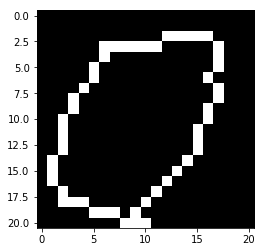

In [47]:
import cv2

list_of_patients = glob.glob('*.pickle')
list_of_patients.sort()

# for name in list_of_patients[98:100]:
    
#     try:
#         print(name)
#         tumor = crop_tumor(name)
#         img = tumor[10].copy()
#         print(type(img))
#         print(img.shape)
#         print(len(img[(img==0)|(img==1)]))
#         img[img==1]=255
#         contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# #         print(type(contours), len(contours))
# #         print(contours[0].shape)
        
#     except:
#         print('Error at patient %s'%name)
#         continue

test_patient = pickle.load(open('R01-001.pickle', 'rb'))
tumor = crop_tumor(test_patient)
img = tumor[5].copy()
print(type(img))
print(img.shape)
print(len(img[(img!=0)|(img!=1)]))
img[img==1]=255
plt.imshow(img,'gray')
contours, hierarchy = cv2.findContours(img.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
perimeter = cv2.arcLength(contours[0],True)
print(contours[0].shape, perimeter)

display = np.zeros((img.shape[0], img.shape[1]))

c_=contours[0].reshape(len(contours[0]),2)
c1, c2 = c_[:,0], c_[:,1]
display[c1,c2]=1

# print(c_)
# for r in range(c_.shape[0]):
#     for i in range(img.shape[0]):
#         for j in range(img.shape[1]):
#             if (c_[r][0]== i and c_[r][1] == j):
#                 display[i][j]=1

                
plt.imshow(display[:21, :21], 'gray')
                
# for i in contours[0]:
#     print(i)

#plt.imshow(contours[0]) ###FIX ###########
# cv2.drawContours(img, contours, -1, (0,255,0), 2)
# print(np.array_equal(img, tumor[10]))
# print(type(img), img.shape)
# plt.imshow(img)
# np.where(img==255)
# cv2.waitKey(20)

# contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
# biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]

# mask = np.zeros(img.shape, np.uint8)
# cv2.drawContours(mask, [biggest_contour], -1, 255, -1)
# cv2.imshow('title', img)
# cv2.waitKey(20)

# im2 = cv2.drawContours(img, contours, 0, (0,255,0), 1)
# f, (ax) = plt.subplots(1, 1, figsize=(20,10),sharey=True)
# ax.grid(False)
# ax.imshow(mask[:25, :25], 'gray')
# plt.show()
# print(np.array_equal(img, mask))

#opencv_versions_contours_working.jpg

In [27]:
c_=contours[0].reshape(25,2)
c_[0]

array([10,  0], dtype=int32)

In [12]:
import numpy as np
import cv2

im = cv2.imread('opencv_versions_contours_working.jpg')
imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,127,255,0)
thresh[(thresh!=0) & (thresh!=127) & (thresh!=255)]
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(im, contours, -1, (0,255,0), 3)
cv2.imshow("title", im)
cv2.waitKey(5)

(4, 1, 2)


-1